## Basic model

In [1]:
#Importing all the libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from itertools import chain
from scipy import stats

from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

import xgboost
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import os
from os import path
from sklearn.metrics import mean_squared_error
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
def splitting_data(X, y):
    column_names = list(X.columns)
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state=3)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size = 0.25, random_state=3)
    return train_X, valid_X, test_X, train_y, test_y, valid_y, column_names


def scale_data(scalar, train_X, valid_X, test_X, column_names):
    scaler = scalar.fit(train_X)
    train_X = scaler.transform(train_X)
    valid_X = scaler.transform(valid_X)
    test_X = scaler.transform(test_X)

    train_X = pd.DataFrame(train_X)
    train_X.columns = column_names

    valid_X = pd.DataFrame(valid_X)
    valid_X.columns = column_names

    test_X = pd.DataFrame(test_X)
    test_X.columns = column_names

    return train_X, valid_X, test_X



In [3]:
df_numeric = pd.read_csv('XAI_data.csv')

In [4]:
non_binary = df_numeric.loc[:, df_numeric.apply(lambda x: x.nunique()) >= 3]

In [5]:
#We make a dataframe with only the non binary columns
df_outlier_removal = df_numeric[list(non_binary.columns)]

#The rows with an outlier in any of the columns get removed based on the z-score
df_outlier_removal = df_outlier_removal[(np.abs(stats.zscore(df_outlier_removal)) < 3).all(axis=1)]

In [6]:
df_binary = df_numeric.drop(columns=list(df_outlier_removal.columns))


In [7]:
#The final dataframe gets created based on the merge of the non-binary and the binary dataframes. 
#We make sure that only the rows that match index will be put in the dataframe so that only the rows
#without an outlier stay in the dataset
df_outlier = df_outlier_removal.merge(df_binary, left_index=True, right_index=True, how='inner')

In [8]:
df_outlier = df_outlier.reset_index(drop=True)


In [9]:
#An x and y get created baesd on the outlier data
X_outlier = df_outlier.drop(columns='Price')
y_outlier = df_outlier['Price']

In [10]:
X_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8047 entries, 0 to 8046
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                8047 non-null   int64  
 1   Plot m2              8047 non-null   int64  
 2   Backgarden m2        8047 non-null   int64  
 3   Volume in m3         8047 non-null   int64  
 4   Bedrooms             8047 non-null   int64  
 5   Bathrooms            8047 non-null   int64  
 6   Toilets              8047 non-null   int64  
 7   Floors               8047 non-null   int64  
 8   Storagespace         8047 non-null   int64  
 9   Garage_amount        8047 non-null   int64  
 10  Balcony_amount       8047 non-null   int64  
 11  Garden_amount        8047 non-null   int64  
 12  Facilities_amount    8047 non-null   int64  
 13  Isolation_amount     8047 non-null   int64  
 14  Heating_amount       8047 non-null   int64  
 15  Energylabel          8047 non-null   f

In [11]:
train_X, valid_X, test_X, train_y, test_y, valid_y, column_names = splitting_data(X_outlier, y_outlier)

train_X, valid_X, test_X = scale_data(scalar=StandardScaler(), train_X=train_X, valid_X=valid_X, test_X=test_X, column_names=column_names)
model = XGBRegressor(n_estimators=80, max_depth=5, eta=0.1, silent=True)
model.fit(train_X, train_y)


[11:24:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [12]:
pred = model.predict(valid_X)
print(r2_score(valid_y, pred))

0.5304262638092041


In [13]:
# Calculate the MSE from the predictions

pred = model.predict(valid_X)
print(mean_squared_error(valid_y, pred))

11825351615.372986


## Dashboard

In [ ]:
# !pip install explainerdashboard
# !pip install dash==2.9.3
# !pip install dash-bootstrap-components==1.5.0
# !pip install dash-html-components

In [14]:
from explainerdashboard import RegressionExplainer
explainer = RegressionExplainer(model, test_X, test_y)

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [15]:
from explainerdashboard import ExplainerDashboard
ExplainerDashboard(explainer).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.31

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8050
 * Running on http://192.168.31.6:8050
Press CTRL+C to quit
192.168.31.6 - - [16/Apr/2025 20:58:49] "GET / HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /assets/bootstrap.min.css?m=1744234573.6540158 HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_9_3m1744235298.12.1.min.js HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_9_3m1744235298.14.0.min.js HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_9_3m1744235298.min.js HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_5_0m1744235303.min.js HTTP/1.1" 200 -
192.168.31.6 - - [16/Apr/2025 20:58:50] "GET /_dash-component-suites/dash/dcc/dash_core_components

In [16]:
from explainerdashboard import InlineExplainer

InlineExplainer(explainer).tab.importances()

#InlineExplainer(explainer).shap.overview()

Dash is running on http://127.0.0.1:8050/



In [17]:
InlineExplainer(explainer).shap.overview()

Dash is running on http://127.0.0.1:8050/



In [18]:
InlineExplainer(explainer).shap.dependence()
# InlineExplainer(explainer).shap.overview()
# InlineExplainer(explainer).tab.importances()

Dash is running on http://127.0.0.1:8050/



## LIME

In [13]:
import lime
import lime.lime_tabular

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_X.values,
    feature_names=train_X.columns,
    class_names=['Laatste vraagprijs'],  # Target variable
    mode='regression'
)

In [15]:
# First data point
instance = valid_X.iloc[0]
exp = explainer.explain_instance(
    instance,
    model.predict,
    num_features=10  
)
exp.show_in_notebook()

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))


c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  binary_column = (inverse_column == first_row[column]).astype(int)
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

In [16]:
print("\nFeature Importance:")

for feature, importance in exp.as_list():
    print(f"{feature}: {importance}")


Feature Importance:
Inhoud in m3 <= -0.68: -160846.54344932633
Herenhuis <= -0.20: -84392.18907807513
Soort bouw <= -0.24: -67590.17392315248
Bathrooms <= -0.26: -66497.26054930763
-0.62 < Sum_Balkon/dakterras <= 1.61: 40855.355700419364
Woonlagen <= -0.27: 35123.07143836162
Aantal slaapkamers <= -1.02: -31355.444796588185
Energielabel <= -0.22: -26440.17147592662
Woonboerderij <= -0.06: -23407.910364499057
Perceel m2 <= -0.41: 21596.35680365509


In [17]:
actual_price = valid_y.iloc[0]
predicted_price = model.predict(valid_X.iloc[[0]])[0] 
print(f"\nActual Price: {actual_price:.2f}")
print(f"Predicted Price: {predicted_price:.2f}")


Actual Price: 299500.00
Predicted Price: 283497.38


In [18]:

# Each data point analysis (5 data points)
for i in range(5):
    print(f"\nData point {i+1} Analysis:")
    instance = valid_X.iloc[i].values  
    exp = explainer.explain_instance(
        instance,
        model.predict,
        num_features=5
    )
    print("Key Influential Characteristics:")
    print(exp.as_list())
    print(f"Actual Price: {valid_y.iloc[i]:.2f}")
    print(f"Predicted Price: {model.predict(valid_X.iloc[[i]])[0]:.2f}")


Data point 1 Analysis:
Key Influential Characteristics:
[('Inhoud in m3 <= -0.68', -157724.58760876357), ('Herenhuis <= -0.20', -81793.02071814834), ('Bathrooms <= -0.26', -68373.12935582364), ('Woonlagen <= -0.27', 34134.99074186992), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 33116.86091234236)]
Actual Price: 299500.00
Predicted Price: 283497.38

Data point 2 Analysis:
Key Influential Characteristics:
[('Herenhuis <= -0.20', -83469.4272321125), ('Bathrooms <= -0.26', -60041.724212166264), ('Soort bouw <= -0.24', -58604.74603691954), ('-0.27 < Woonlagen <= 0.95', -38778.29848167921), ('Sum_Balkon/dakterras <= -0.62', -31912.103199796155)]
Actual Price: 330000.00
Predicted Price: 410295.28

Data point 3 Analysis:
Key Influential Characteristics:
[('Inhoud in m3 <= -0.68', -163485.42849995487), ('Herenhuis > -0.20', 92818.12733610232), ('Soort bouw <= -0.24', -63869.54486931252), ('Woonlagen <= -0.27', 37476.60429069495), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 35460.29185935611)]
Actua

Data point 4 analysis is pretty far

In [19]:
# 1. Large error cases analysis
def analyze_large_errors(valid_X, valid_y, model, explainer, threshold=100000):
    predictions = model.predict(valid_X)
    errors = np.abs(predictions - valid_y)
    
    import pandas as pd
    error_df = pd.DataFrame({
        'actual': valid_y,
        'predicted': predictions,
        'error': errors
    }, index=valid_X.index)
    
    # Find cases with large errors
    large_errors = error_df[error_df['error'] > threshold]
    
    print(f"Cases with large errors (above {threshold:,}): {len(large_errors)}")
    
    # Top 5 large error cases analysis
    for idx in large_errors.index[:5]:
        print(f"\nLarge error case analysis:")
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=7
        )
        print("Key Influential Characteristics:")
        print(exp.as_list())
        print(f"Actual Price: {large_errors.loc[idx, 'actual']:,.2f}")
        print(f"Predicted Price: {large_errors.loc[idx, 'predicted']:,.2f}")
        print(f"Error: {large_errors.loc[idx, 'error']:,.2f}")


# Run the function
print("1. Large error case analysis")
analyze_large_errors(valid_X, valid_y, model, explainer)

1. Large error case analysis
Cases with large errors (above 100,000): 80

Large error case analysis:
Key Influential Characteristics:
[('Herenhuis <= -0.20', -88891.64230109246), ('Soort bouw <= -0.24', -57312.29283735698), ('Bathrooms <= -0.26', -51697.93782377477), ('Grachtenpand <= -0.02', 49578.06423031015), ('-0.27 < Woonlagen <= 0.95', -33275.61487029327), ('-0.62 < Sum_Balkon/dakterras <= 1.61', 32122.41201509546), ('Kelder <= -0.23', 23289.148140789042)]
Actual Price: 315,000.00
Predicted Price: 380,108.38
Error: 253,893.94

Large error case analysis:
Key Influential Characteristics:
[('Inhoud in m3 > 0.55', 195054.12562583535), ('Herenhuis <= -0.20', -83181.31797644425), ('Soort bouw <= -0.24', -64630.411895696656), ('Bathrooms <= -0.26', -63017.92088213479), ('Grachtenpand <= -0.02', 52653.27206148748), ('Sum_Balkon/dakterras <= -0.62', -38214.80526710899), ('Woonboerderij <= -0.06', 29653.291692306546)]
Actual Price: 740,000.00
Predicted Price: 348,285.84
Error: 287,019.16



In [20]:
# 2. Feature impact distribution analysis
def analyze_feature_impact_distribution(valid_X, model, explainer, n_samples=100):
    feature_impacts = {}
    
    # Random sample selection (based on index)
    sample_indices = np.random.choice(valid_X.index, min(n_samples, len(valid_X)), replace=False)
    
    for idx in sample_indices:
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=len(valid_X.columns)
        )
        
        # Save the impact of each feature
        for feature, impact in exp.as_list():
            if feature not in feature_impacts:
                feature_impacts[feature] = []
            feature_impacts[feature].append(impact)
    
    # Calculate the statistics of the impact of each feature
    
    stats = {}
    for feature, impacts in feature_impacts.items():
        stats[feature] = {
            'mean_impact': np.mean(impacts),
            'std_impact': np.std(impacts),
            'min_impact': np.min(impacts),
            'max_impact': np.max(impacts)
        }
    
    stats_df = pd.DataFrame(stats).T
    print("Feature impact statistics:")
    print(stats_df.sort_values('mean_impact', key=abs, ascending=False))


print("\n2. Feature impact distribution analysis")
analyze_feature_impact_distribution(valid_X, model, explainer)



2. Feature impact distribution analysis
Feature impact statistics:
                                       mean_impact   std_impact  \
Inhoud in m3 > 0.55                  196567.190391  2918.233919   
Inhoud in m3 <= -0.68               -160819.291815  2091.780072   
Herenhuis <= -0.20                   -88011.485000  7953.335259   
Herenhuis > -0.20                     80545.303601  1637.915565   
Bathrooms > -0.26                     64214.493108  4626.066516   
...                                            ...          ...   
-1.02 < Aantal slaapkamers <= -0.11      17.308890  2992.513465   
Sum_Schuur/berging <= 0.53                0.000000     0.000000   
Woonboot <= 0.00                          0.000000     0.000000   
Eengezinswoning <= 0.43                   0.000000     0.000000   
Toilets <= 0.00                           0.000000     0.000000   

                                        min_impact     max_impact  
Inhoud in m3 > 0.55                  191046.906369  202368.


3. Visualize the distribution of the top features impact


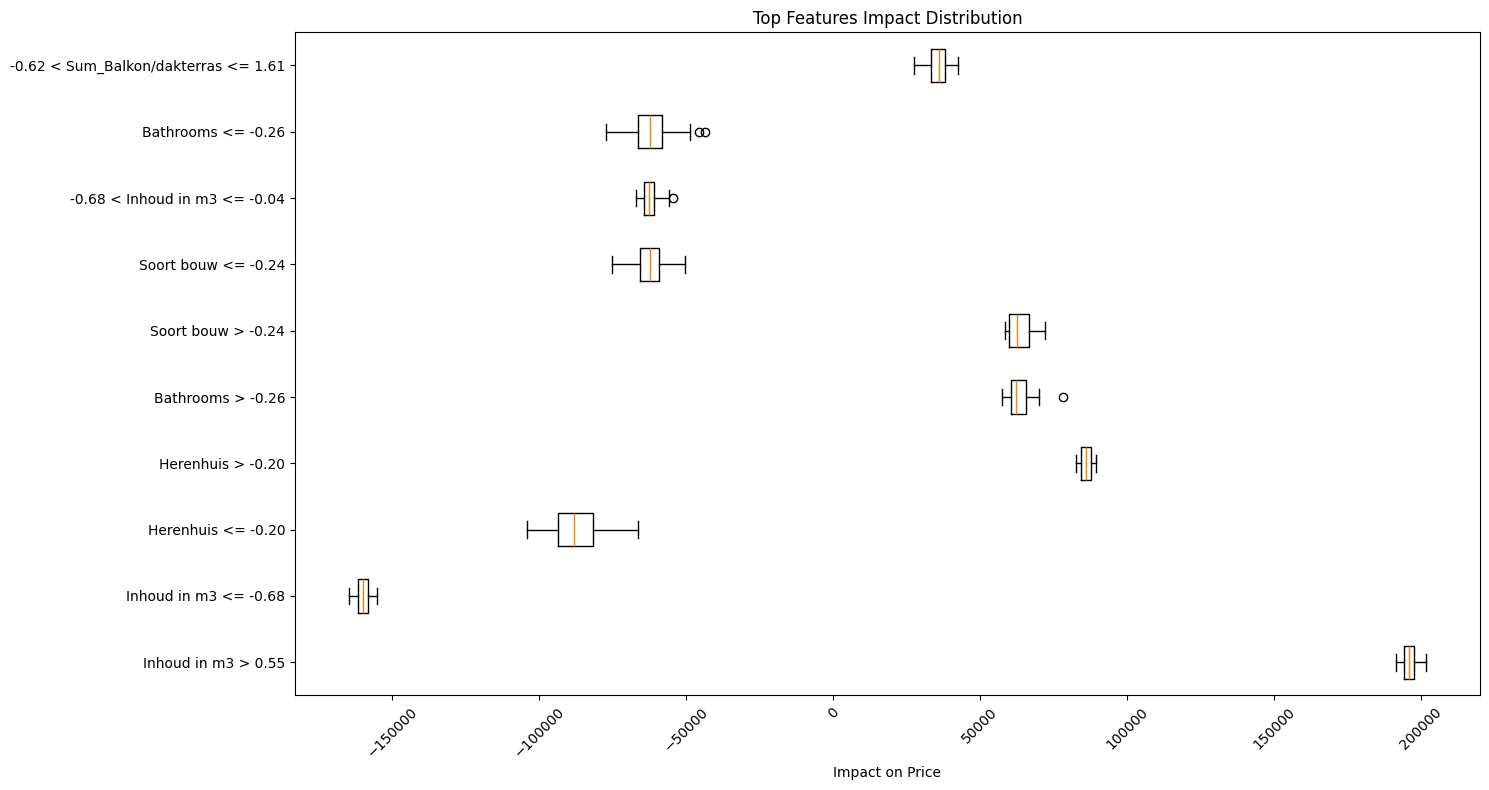

In [21]:
def plot_feature_importance_distribution(valid_X, model, explainer, n_samples=100, top_n=10):
    feature_impacts = {}
    sample_indices = np.random.choice(valid_X.index, min(n_samples, len(valid_X)), replace=False)
    
    for idx in sample_indices:
        instance = valid_X.loc[idx].values
        exp = explainer.explain_instance(
            instance,
            model.predict,
            num_features=len(valid_X.columns)
        )
        
        for feature, impact in exp.as_list():
            if feature not in feature_impacts:
                feature_impacts[feature] = []
            feature_impacts[feature].append(impact)
    
    # Calculate the average impact and select the top features
    mean_impacts = {f: np.mean(impacts) for f, impacts in feature_impacts.items()}
    top_features = sorted(mean_impacts.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
    
    # Create a boxplot
    plt.figure(figsize=(15, 8))
    plot_data = []
    labels = []
    
    for feature, _ in top_features:
        plot_data.append(feature_impacts[feature])
        labels.append(feature)
    
    plt.boxplot(plot_data, labels=labels, vert=False)
    plt.title('Top Features Impact Distribution')
    plt.xlabel('Impact on Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



print("\n3. Visualize the distribution of the top features impact")
plot_feature_importance_distribution(valid_X, model, explainer)

### LIME Analysis of House Price Prediction Model

#### Feature Impact Distribution Analysis

##### 1. Volume Impact (Inhoud in m3)
- **Very Small Volume (<= -0.68)**
  - Strong negative impact: > -€100,000
  - Most consistent negative effect
- **Very Large Volume (> 0.55)**
  - Highest positive impact: ~+€150,000
  - Shows significant price premium
- **Medium Volume (-0.68 to -0.04)**
  - Moderate negative impact
  - Shows consistent effect pattern

##### 2. Building Type Impact (Soort bouw)
- **Below Reference (<= -0.24)**
  - Negative impact: ~-€50,000
  - Relatively small variance
- **Above Reference (> -0.24)**
  - Positive impact: ~+€100,000
  - High consistency in effect
- **Notable**: Shows clear binary impact pattern

##### 3. Bathroom Impact
- **Fewer Bathrooms (<= -0.26)**
  - Negative impact: ~-€50,000
  - Consistent effect
- **More Bathrooms (> -0.26)**
  - Positive impact: ~+€50,000
  - Symmetrical effect pattern

##### 4. Mansion Type Impact (Herenhuis)
- **Non-Mansion (<= -0.20)**
  - Moderate negative impact: ~-€25,000
  - Relatively consistent effect
- **Mansion (> -0.20)**
  - Positive impact: ~+€50,000
  - Clear price premium

##### 5. Balcony/Roof Terrace Impact (Sum_Balkon/dakterras)
- **Limited/No Balcony (<= -0.62)**
  - Slight negative impact
  - Low variance in effect
- **Notable**: Less influential compared to other features

#### Key Insights

1. **Primary Price Drivers**
   - House volume (Inhoud in m3) is the strongest price determinant
   - Building type shows second highest impact
   - Bathroom count demonstrates significant influence

2. **Effect Consistency**
   - Most features show consistent effects (small box sizes)
   - Volume shows highest variance in impact
   - Building type shows very consistent effects

3. **Practical Implications**
   - Volume should be primary consideration in price estimation
   - Building type significantly affects property value
   - Bathroom count offers predictable price impacts


## SHAP

In [1]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
# initialize SHAP explainer
explainer = shap.Explainer(model, train_X)

# calculate SHAP values
shap_values = explainer(test_X)

## Tips
### Want to analyze "whether the model has learned the real house price pattern" → explain test_X
### Want to analyze "whether the feature importance has changed during a certain model parameter adjustment" → explain valid_X

### 📊 SHAP Summary Plot Analysis (Dot Plot)

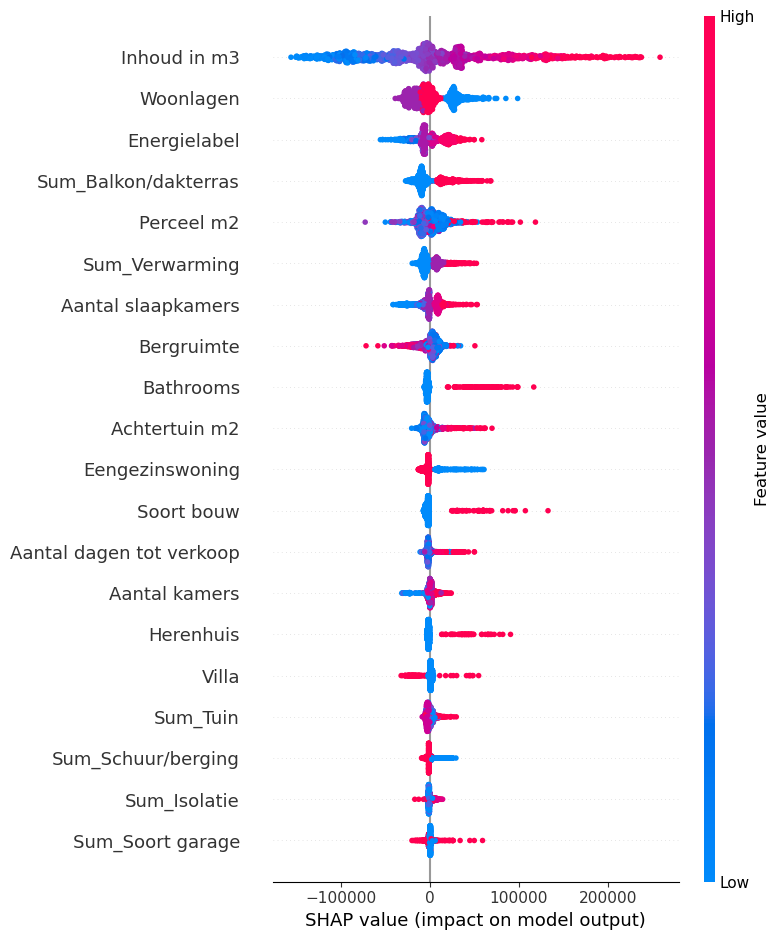

In [ ]:
# Summary plot: Overview of the impact of each feature on the prediction

shap.summary_plot(shap_values, test_X, plot_type="dot")


The SHAP summary plot above provides an overview of how each feature affects the model's predictions across all test samples. Each dot represents a SHAP value for a specific feature and a specific observation (house).

- **X-axis (SHAP value)**: Indicates the impact of that feature on the model output.
    - A SHAP value > 0 means the feature increases the predicted price.
    - A SHAP value < 0 means the feature decreases the predicted price.
- **Color**: Represents the actual feature value.
    - **Red** = high feature value
    - **Blue** = low feature value

#### 🔝 Most impactful features:
1. **Inhoud in m3 (Volume)**: Larger houses (red dots) tend to increase predicted price, while smaller houses (blue dots) reduce it.
2. **Woonlagen (Number of floors)**: More floors generally increase price.
3. **Energielabel (Energy label)**: Low energy efficiency (blue) has a strong negative effect on price.
4. **Sum_Balkon/dakterras (Balcony/roof terrace)**: Absence or poor quality of balconies reduces price.
5. **Perceel m2 (Plot size)**: Larger plots contribute positively to price.

#### 🧠 Observations:
- Many features have both positive and negative SHAP values depending on the value of the feature, indicating **non-linear relationships**.
- Features like `Aantal slaapkamers` and `Sum_Verwarming` also show clear value-dependent effects on price.
- Some features like `Eengezinswoning`, `Villa`, or `Sum_Soort garage` appear less impactful overall but may still be relevant in specific cases.

#### 💡 Conclusion:
This plot helps identify which features are most important for model prediction and how their values influence the model's output. It supports global interpretability of the model and provides guidance on which variables the model relies on most for estimating house prices.


### 📊 SHAP Bar Plot Analysis: Global Feature Importance



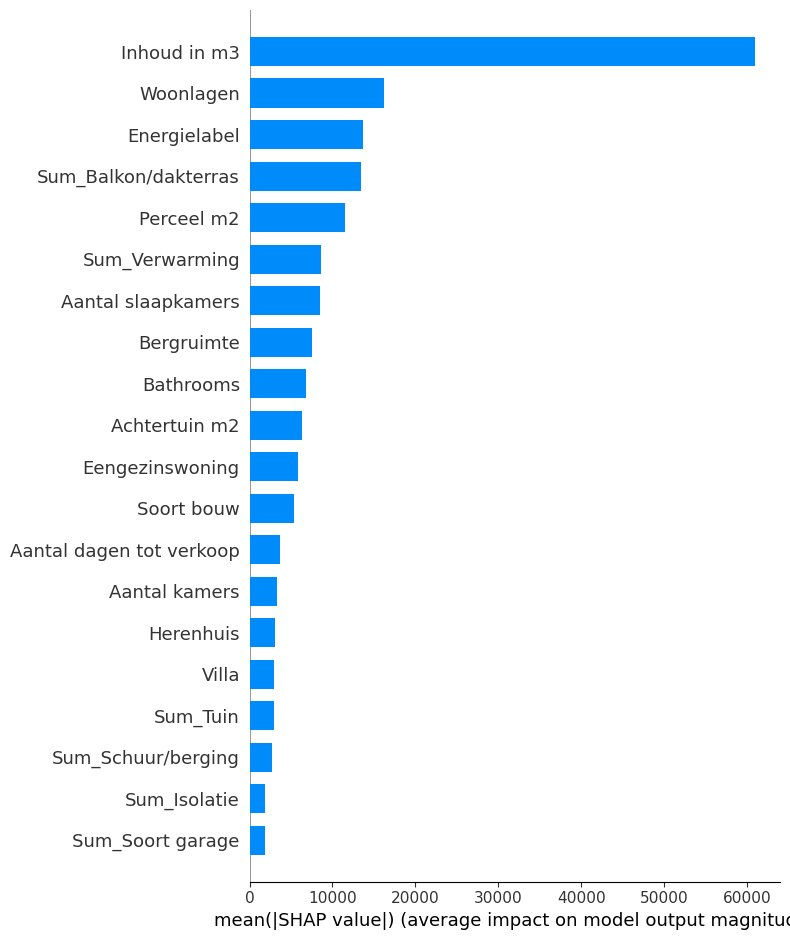

In [ ]:
# Bar Plot： Feature importance ranking

shap.summary_plot(shap_values, test_X, plot_type="bar")


The bar plot above displays the global importance of each feature used by the XGBoost house price prediction model. Each bar represents the **mean absolute SHAP value** of that feature across all test samples, reflecting its average impact on the model output.

#### 🔝 Top 5 Most Important Features:
1. **Inhoud in m3 (Volume in cubic meters)**: This is the most influential feature. Larger volume homes typically have higher predicted prices.
2. **Woonlagen (Number of floors)**: Houses with more floors are valued higher.
3. **Energielabel (Energy efficiency label)**: Poor energy ratings significantly reduce predicted house prices.
4. **Sum_Balkon/dakterras (Balcony/Roof terrace)**: Outdoor spaces positively affect house valuation.
5. **Perceel m2 (Land size)**: Indicates that more land generally correlates with higher value.

#### 🧠 Interpretation:
- Features at the top have the **strongest influence** on the model’s predictions.
- Lower-ranked features such as `Sum_Soort garage`, `Sum_Isolatie`, or `Villa` have minimal impact on predictions, either due to lack of variance or weak correlation with price.
- This plot helps us understand which attributes are **globally most important** and should be prioritized when improving or auditing the model.

#### 💡 Use Case:
This visualization is particularly useful for **feature selection**, **model debugging**, and **explaining model behavior** to stakeholders, especially in real estate pricing or feature engineering discussions.


### 🔍 SHAP Waterfall Plot Analysis: Single House Prediction



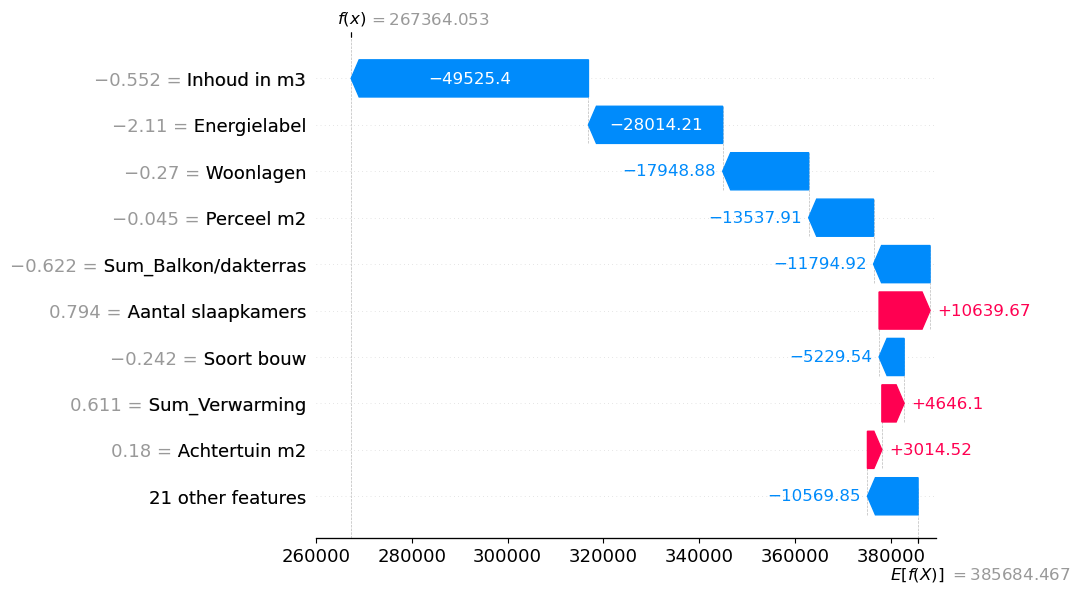

In [18]:
# Force Plot: Visualize the impact of each feature on a single prediction

# eg. explain the first prediction
shap.plots.waterfall(shap_values[0])


The waterfall plot above provides a detailed breakdown of the SHAP values for one individual prediction made by our XGBoost model. The predicted price of the house is **€267,364**, significantly lower than the model’s average predicted value (**€385,684**), which represents the base value.

#### 🔻 Features that pushed the price **down**:
- **Inhoud in m3 (Volume)**: Contributed **-€49,525**, indicating that a small house volume significantly reduced the estimated value.
- **Energielabel (Energy label)**: Contributed **-€28,014**, showing that poor energy efficiency led to a lower price.
- **Woonlagen (Number of floors)**: Contributed **-€17,949**, possibly due to having fewer usable floors.
- **Perceel m2 (Lot size)** and **Sum_Balkon/dakterras (Balcony/roof terrace)** also negatively affected the valuation.
- **Soort bouw (Construction type)** and the cumulative effect of 21 other features contributed to further reduction.

#### 🔺 Features that pushed the price **up**:
- **Aantal slaapkamers (Number of bedrooms)**: Contributed **+€10,639**, indicating more bedrooms increased the price.
- **Sum_Verwarming (Heating facilities)**: Added **+€4,646**.
- **Achtertuin m2 (Backyard size)**: Slightly improved the estimate by **+€3,014**.

#### 💡 Conclusion:
The overall impact of the negative features significantly outweighs the positive ones, resulting in a much lower predicted house price compared to the model's base value. This visualization helps us understand the contribution of each feature and increases the transparency of the model’s decision-making.


### 🔍 SHAP Force Plot Analysis for a Single Prediction



In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, test_X.iloc[0])


The SHAP force plot above explains the prediction of a single house price made by the trained XGBoost model. The predicted value is **€267,364**, which is **lower than the model's base value of approximately €335,700**. This base value represents the average model prediction across all training data, i.e., the expected value if no feature information were known.

The colored arrows show how each feature contributes to moving the prediction away from the base value:

#### 🔺 Features that increase the predicted price (shown in red):
- **Aantal slaapkamers (Number of bedrooms)**: Contributed +0.7935, indicating that a higher number of bedrooms pushed the prediction up by approximately €79,350.
- **Sum_Verwarming (Heating-related features)**: Contributed +0.6112, suggesting that the presence or quality of heating systems positively influenced the price (approx. +€61,120).

#### 🔻 Features that decrease the predicted price (shown in blue):
- **Energielabel (Energy label)**: Contributed -2.11, significantly lowering the price prediction by approximately €211,000. A poor energy label appears to be the dominant negative factor.
- **Inhoud in m3 (Volume in cubic meters)**: Contributed -0.5521, indicating a relatively smaller or less spacious property.
- **Woonlagen (Number of floors)**: Contributed -0.2701, possibly due to fewer stories in the house.
- **Sum_Balkon/dakterras (Balcony or roof terrace)**: Contributed -0.6215, implying the absence or lower quality of these outdoor features.
- **Soort bouw (Type of construction)**: Contributed -0.2425, suggesting the building type may be less desirable.

#### 💡 Summary:
The prediction is mainly pulled downward by the **poor energy label**, which heavily penalizes the estimated price. Although certain features (e.g., number of bedrooms, heating) push the price up, they are not strong enough to offset the large negative impacts. This analysis enhances our understanding of how the model reaches its decision and which features are most influential for this particular house.


### 🔍 SHAP Force Plot Comparison

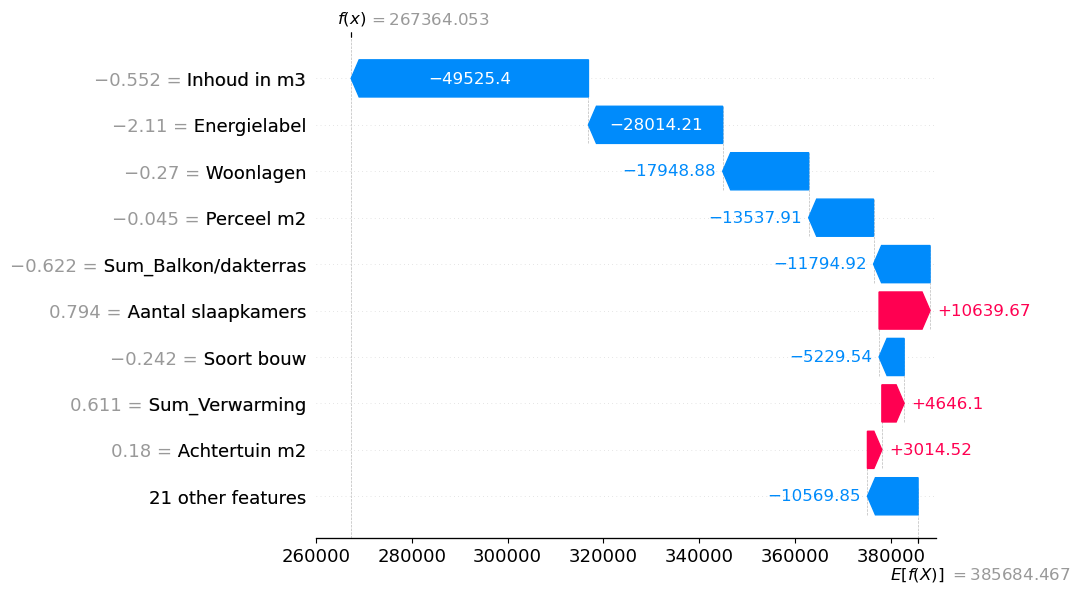

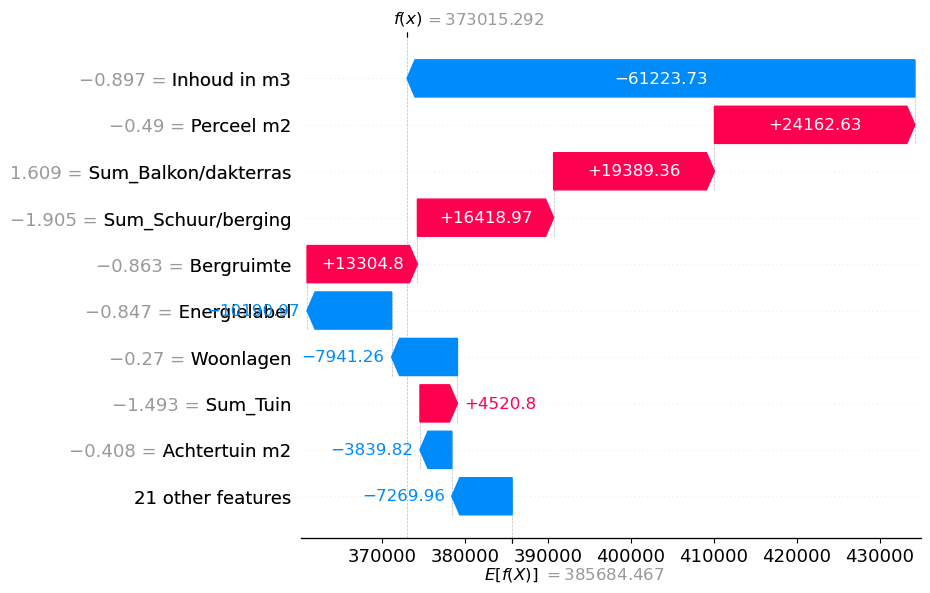

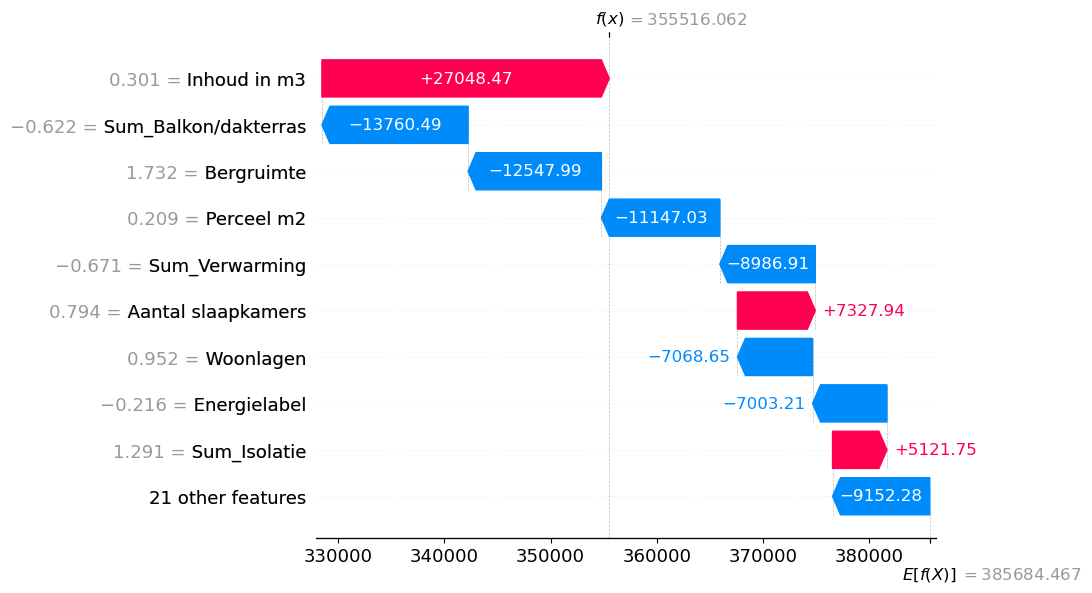

In [22]:
# compare the different features' impact on first ten predictions
for i in range(3):
    shap.plots.waterfall(shap_values[i])


In [23]:
def show_shap_force_plot(sample_index, shap_values, explainer, data):
    """
    Display the SHAP force plot for a given sample.

    Parameters:
    - sample_index: index of the sample to explain
    - shap_values: computed SHAP values (e.g., shap_values = explainer(test_X))
    - explainer: SHAP explainer object
    - data: the dataset (e.g., test_X)
    """
    print(f"🔍 Displaying SHAP force plot for sample index: {sample_index}")
    display(shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[sample_index].values,
        features=data.iloc[sample_index],
        feature_names=data.columns
    ))

def compare_multiple_samples(indices, shap_values, explainer, data):
    """
    Show force plots for a list of sample indices.
    """
    for idx in indices:
        show_shap_force_plot(idx, shap_values, explainer, data)


In [24]:
compare_multiple_samples([0, 1, 5], shap_values, explainer, test_X)


🔍 Displaying SHAP force plot for sample index: 0


🔍 Displaying SHAP force plot for sample index: 1


🔍 Displaying SHAP force plot for sample index: 5



Samples 0, 1, and 5

We compared the SHAP explanations for three different house samples to explore how feature contributions vary across instances.

#### 📌 Sample 0 (Predicted price ≈ €267,364)
- Most influential negative factors: 
  - **Energielabel (-2.11)** and **Inhoud in m³ (-0.552)** significantly decreased the predicted price.
- Positive contributors:
  - **Aantal slaapkamers (0.79)** and **Sum_Verwarming (0.61)** slightly raised the estimate.

#### 📌 Sample 1 (Predicted price ≈ €373,015)
- Strong upward SHAP contributions from:
  - **Sum_Balkon/dakterras (1.61)** and **Sum_Schuur/berging (1.90)** indicating valuable outdoor and storage spaces.
- Moderate negative effect from:
  - **Inhoud in m³ (-0.89)** and **Energielabel (-0.85)**

#### 📌 Sample 5 (Predicted price ≈ €369,368)
- Main positive factors:
  - **Sum_Balkon/dakterras (1.61)** and **Sum_Verwarming (1.89)**
- Largest negative SHAP effects:
  - **Inhoud in m³ (-0.93)**, **Aantal slaapkamers (-1.02)**, and **Woonlagen (-1.49)**

#### 🧠 Insights:
- While **Inhoud in m³** consistently reduces predicted prices in all three samples, its magnitude varies per sample.
- Features like **Balkon/dakterras** and **Verwarming** show **strong positive contributions** when present and well-equipped.
- Some features flip impact across samples — e.g., **Aantal slaapkamers** positively contributes in Sample 0 but negatively in Sample 5, indicating contextual and non-linear effects in the model.

This comparison highlights how SHAP enables us to explain and contrast predictions at the individual instance level, reinforcing the model’s transparency and helping validate or challenge its reasoning.


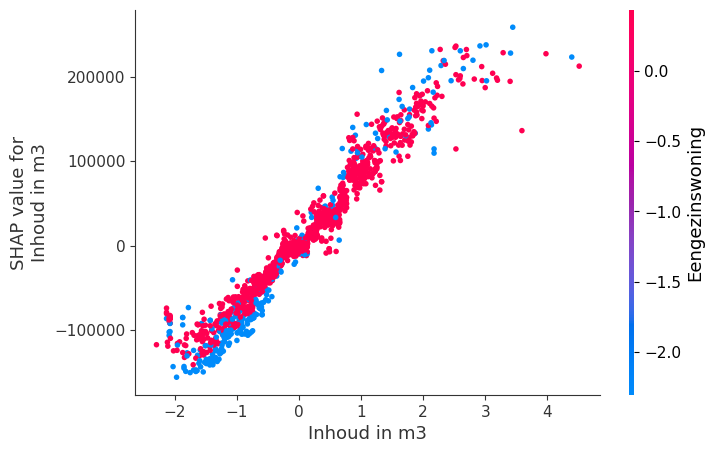

In [ ]:
# Dependence Plot

shap.dependence_plot("Inhoud in m3", shap_values.values, test_X)


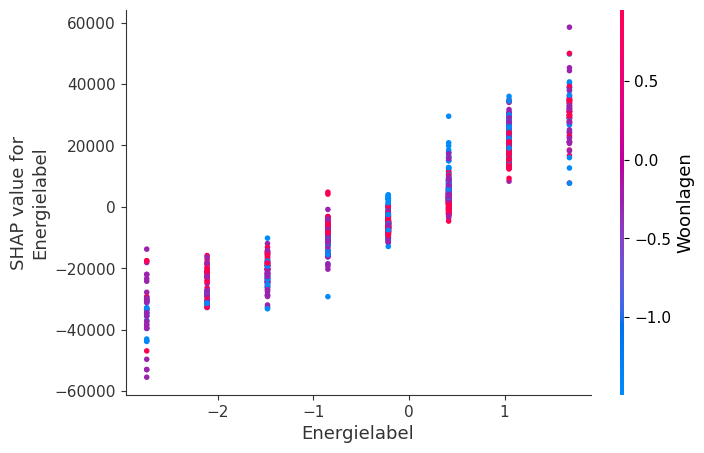

In [26]:
# self-defined the interaction feature want to analyze
shap.dependence_plot("Energielabel", shap_values.values, test_X, interaction_index="Woonlagen")


#### 📈 Plot 1: Inhoud in m³ vs SHAP value (Interaction with Eengezinswoning)

This plot shows a strong **positive correlation** between the house volume (`Inhoud in m³`) and its SHAP value. This implies that larger homes generally contribute positively to the predicted price.

- The relationship is clearly **non-linear**: below 0, volume has a steep negative impact, but above 0, it positively boosts the price.
- The color gradient (based on `Eengezinswoning`) reveals interaction:
  - **Red dots (Eengezinswoning=True)**: The positive effect of volume is stronger.
  - **Blue dots (False)**: Even large homes do not benefit as much.

This indicates that **volume matters more in single-family homes**.

---

#### 📈 Plot 2: Energielabel vs SHAP value (Interaction with Woonlagen)

This plot highlights how **energy efficiency** affects price prediction.

- As `Energielabel` increases (better rating), its SHAP value increases as well, meaning **better energy labels increase the predicted price**.
- Interaction with `Woonlagen` (number of floors):
  - **Red dots (more floors)**: Houses with better energy labels and more floors have significantly higher price contributions.
  - **Blue dots (fewer floors)**: Poor energy labels have a stronger negative effect.

This suggests an **interaction effect** where energy efficiency is more rewarded in multi-story houses.

---

These dependence plots provide a nuanced understanding of how the model incorporates **non-linear effects and feature interactions**, which would be difficult to capture with standard feature importance metrics alone.


### 🔍 SHAP Interaction Summary Plot Analysis



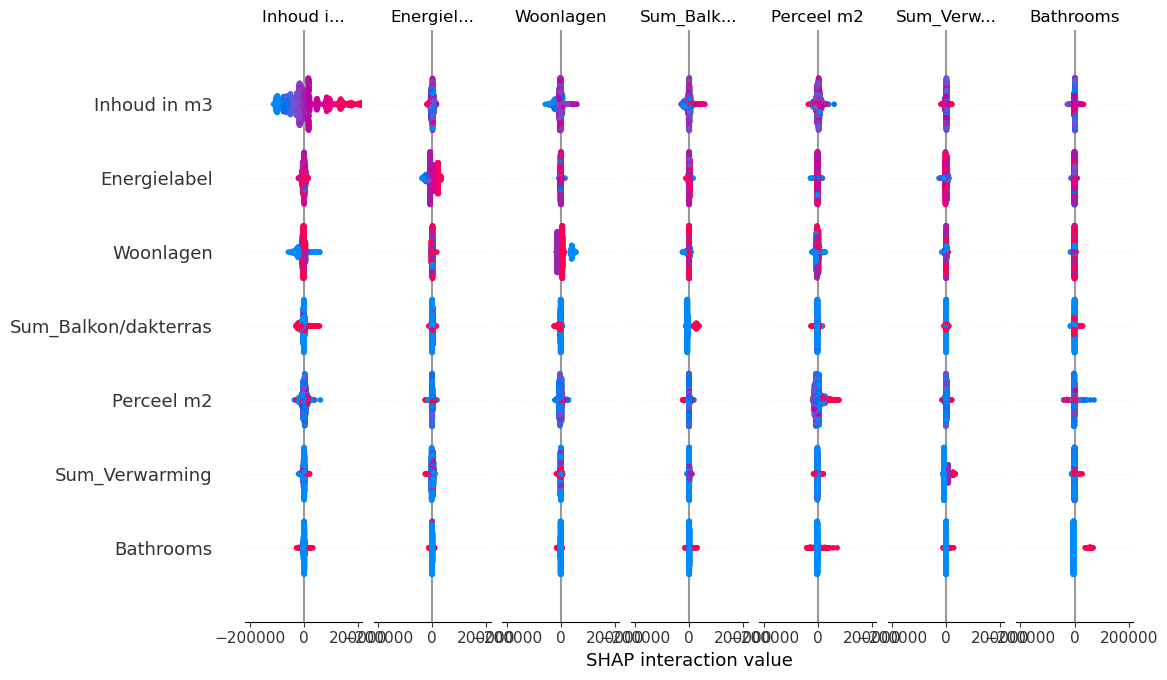

In [27]:
explainer = shap.TreeExplainer(model, feature_perturbation="interventional")
shap_interaction_values = explainer.shap_interaction_values(test_X)
shap.summary_plot(shap_interaction_values, test_X)


This interaction plot highlights not just how individual features affect predictions (main effects), but also how **pairs of features interact** to influence the model output.

#### 🧩 Key takeaways:

- **Diagonal elements** represent the main SHAP effect of each feature.
  - `Inhoud in m³` shows the strongest main effect, confirming it is the most influential standalone feature.
- **Off-diagonal elements** represent SHAP interaction values between feature pairs.
  - Significant interactions are seen between:
    - `Inhoud in m³` and `Energielabel`
    - `Inhoud in m³` and `Woonlagen`
    - `Energielabel` and `Woonlagen`

These interactions suggest that:
- The effect of **energy efficiency** (Energielabel) may be amplified in homes with larger **volume** or more **floors**.
- The model does not treat features independently, but instead captures **non-linear, feature-combined patterns** that impact price.

#### 💡 Why it matters:
Understanding feature interactions is key in real estate models, where variables like house size, energy efficiency, and structure type often **combine** to determine value. SHAP interaction values help reveal these hidden synergies that traditional importance plots may miss.


### 🧪 SHAP Error Analysis: Largest Prediction Residual

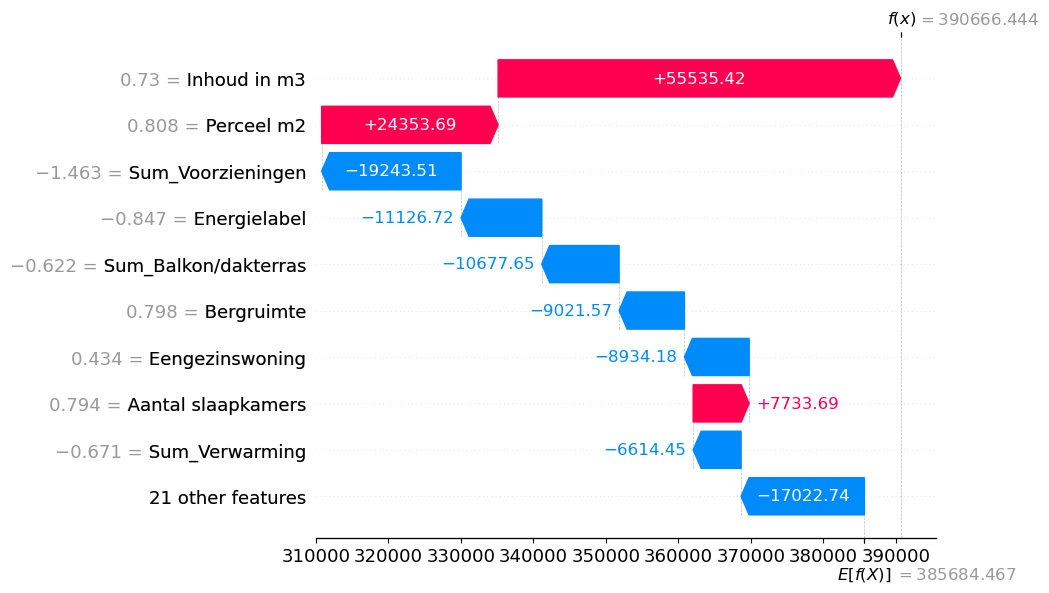

In [28]:
# predict residual
y_pred = model.predict(test_X)
residuals = test_y - y_pred

# find the index of the largest absolute residual
idx = np.argmax(np.abs(residuals))
shap.plots.waterfall(shap_values[idx])


To diagnose potential model issues, we analyzed the test sample with the largest absolute residual (difference between predicted and actual price). The SHAP waterfall plot explains the model's prediction for this outlier.

- **Model prediction**: €390,666  
- **Baseline (expected value)**: €385,684  
- **Residual**: This sample had the largest gap between `y_true` and `y_pred`, suggesting potential over/under-prediction.

#### 🔺 Features that increased the prediction:
- **Inhoud in m³ (house volume)**: +€55,535 — A large house volume substantially raised the predicted price.
- **Perceel m² (land size)**: +€24,353 — Larger plot size also contributed positively.
- **Aantal slaapkamers (bedroom count)**: +€7,733

#### 🔻 Features that decreased the prediction:
- **Sum_Voorzieningen (amenities score)**: -€19,243 — Lack of nearby amenities led to a sharp drop.
- **Energielabel (energy label)**: -€11,126 — Poor energy efficiency reduced the predicted price.
- **Sum_Balkon/dakterras (balcony/terrace)**: -€10,677 — Outdoor space limitations impacted valuation.

#### 💡 Conclusion:
Although the model heavily relied on size-related features like volume and land, it may have underestimated the negative impact of poor amenities and energy efficiency. This analysis helps identify potential blind spots and guide model refinement or feature engineering.

## Neural Network

In [14]:
# Load all names of features into feauture_names

feature_names = df_outlier.columns.tolist()

In [15]:
torch.manual_seed(1234)
np.random.seed(1234)

In [16]:
# Convert to PyTorch tensors
X_train = torch.tensor(train_X.to_numpy()).float()
y_train = torch.tensor(train_y.to_numpy()).float().contiguous().view(-1, 1)

X_test = torch.tensor(test_X.to_numpy()).float()
y_test = torch.tensor(test_y.to_numpy()).float().contiguous().view(-1, 1)

# Create datasets and data loaders
datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [17]:
# Improved hyperparameters for better performance
batch_size = 128  # Further increased batch size for faster training
num_epochs = 200  # Increased epochs for better convergence
learning_rate = 0.01  # Reduced learning rate for more stable optimization
size_hidden1 = 256  # Increased size of the first hidden layer for better feature extraction
size_hidden2 = 128  # Increased size of the second hidden layer
size_hidden3 = 64   # Increased size of the third hidden layer
size_hidden4 = 1    # Output layer remains the same
dropout_rate = 0.3  # Dropout rate for regularization

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30, size_hidden1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        x = self.dropout1(self.relu1(self.lin1(input)))
        x = self.dropout2(self.relu2(self.lin2(x)))
        x = self.dropout3(self.relu3(self.lin3(x)))
        return self.lin4(x)

In [18]:
model = Model()
model.train()
criterion = nn.MSELoss(reduction='sum')

In [19]:
def train(model_inp, train_iter, val_iter=None, num_epochs=num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    for epoch in range(num_epochs):
        model_inp.train()
        running_loss = 0.0

        for inputs, labels in train_iter:
            outputs = model_inp(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            # Optional: gradient clipping
            nn.utils.clip_grad_norm_(model_inp.parameters(), max_norm=5.0)
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        if epoch % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss:.4f}")

            if val_iter:
                model_inp.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for val_inputs, val_labels in val_iter:
                        val_outputs = model_inp(val_inputs)
                        val_loss += criterion(val_outputs, val_labels).item()
                print(f"          Validation Loss: {val_loss:.4f}")


In [20]:
def train_load_save_model(model_obj, model_path, train_iter, val_iter=None):
    if os.path.exists(model_path):
        print('Model already trained. Loading model from path:', model_path)
        model_obj.load_state_dict(torch.load(model_path))
    else:
        # train model
        train(model_obj, train_iter, val_iter)
        print('Finished training the model. Saving the model to the path:', model_path)
        torch.save(model_obj.state_dict(), model_path)


In [22]:
SAVED_MODEL_PATH = 'california_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH, train_iter)

Epoch [1/200], Train Loss: 126440107687936.0000
Epoch [21/200], Train Loss: 68828601648128.0000
Epoch [41/200], Train Loss: 67255554724864.0000
Epoch [61/200], Train Loss: 61941848151040.0000
Epoch [81/200], Train Loss: 61327524071424.0000
Epoch [101/200], Train Loss: 58698923518976.0000
Epoch [121/200], Train Loss: 57277029388288.0000
Epoch [141/200], Train Loss: 58958219831296.0000
Epoch [161/200], Train Loss: 56683776784384.0000
Epoch [181/200], Train Loss: 57410154303488.0000
Finished training the model. Saving the model to the path: california_model.pt


In [23]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  110587.805


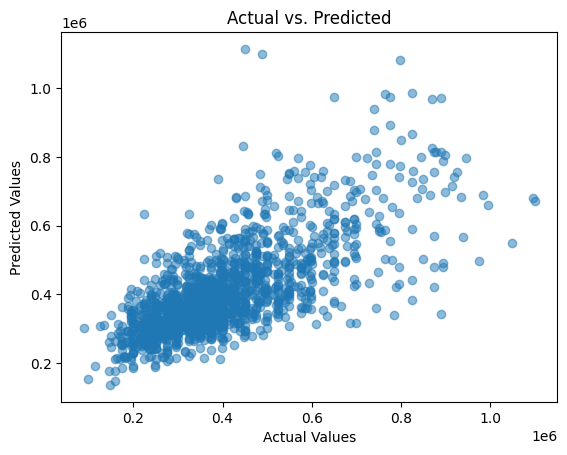

In [24]:
plt.scatter(y_test.detach().numpy(), outputs.detach().numpy(), alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.show()

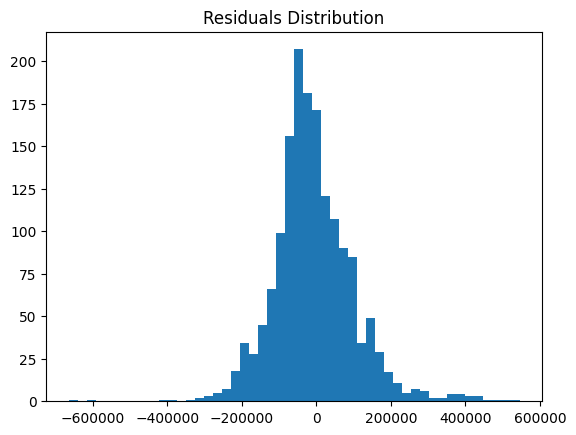

In [25]:
residuals = y_test.detach().numpy() - outputs.detach().numpy()
plt.hist(residuals, bins=50)
plt.title("Residuals Distribution")
plt.show()

In [26]:
# We define different feature attributtion based methods here:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\HUAWEI\AppData\Local\Programs\Python\Python312\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


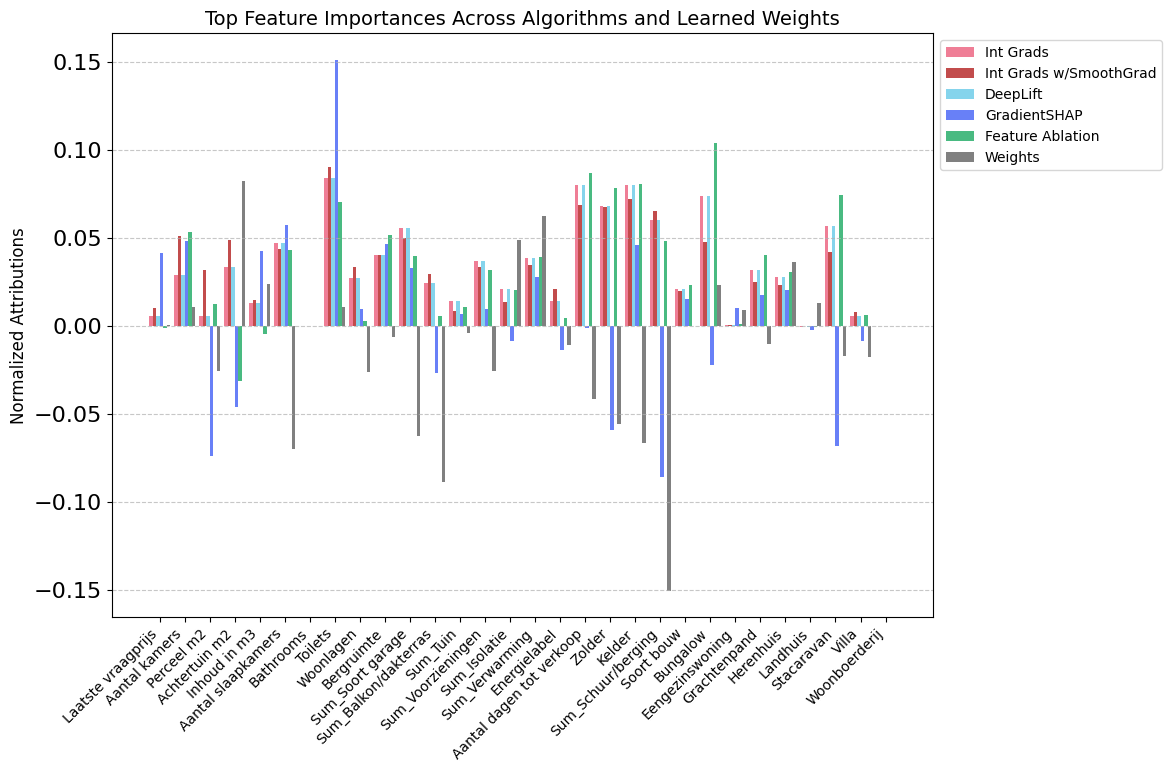

In [30]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

# Plot
width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad', 'DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(12, 8))
ax = plt.subplot()
ax.set_title('Top Feature Importances Across Algorithms and Learned Weights', fontsize=14)
ax.set_ylabel('Normalized Attributions', fontsize=12)

# Bar plots
ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c', label=legends[0])
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000', label=legends[1])
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0', label=legends[2])
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center', alpha=0.8, color='#4260f5', label=legends[3])
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81', label=legends[4])
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey', label=legends[5])

# Add gridlines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Adjust x-axis labels
ax.set_xticks(x_axis_data + 2.5 * width)
ax.set_xticklabels(x_axis_data_labels, rotation=45, ha='right', fontsize=10)

# Add legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.show()

#### Integrated Gradients (Int Grads)
- Measures the contribution of each feature by integrating gradients along the path from a baseline input to the actual input.
- Useful for understanding how features influence predictions in a continuous manner.

#### Integrated Gradients with SmoothGrad (Int Grads w/SmoothGrad)
- Combines Integrated Gradients with noise to smooth out the attributions.
- Reduces noise and highlights consistent feature contributions.

#### DeepLift
- Compares the difference in predictions between a baseline and the actual input, attributing the difference to each feature.
- Captures both positive and negative contributions effectively.

#### GradientSHAP
- Averages attributions over multiple random baseline inputs using SHAP (SHapley Additive exPlanations).
- Accounts for variability in feature importance due to different baselines.

#### Feature Ablation
- Measures the change in model output when a feature is removed or replaced with a baseline value.
- Highlights the direct impact of each feature on the prediction.

#### Weights
- Represents the learned weights of the first layer of the neural network.
- Indicates the raw importance of features as perceived by the model, without considering interactions or non-linearities.

---

#### Key Insights
1. **Consistency Across Models**: Features with high importance across multiple methods are likely critical for the model's predictions.
2. **Differences Between Models**: Variations in attributions highlight how different methods capture feature importance differently (e.g., linear vs. non-linear relationships).
3. **Negative Contributions**: Negative bars indicate features that reduce the prediction value, while positive bars increase it.

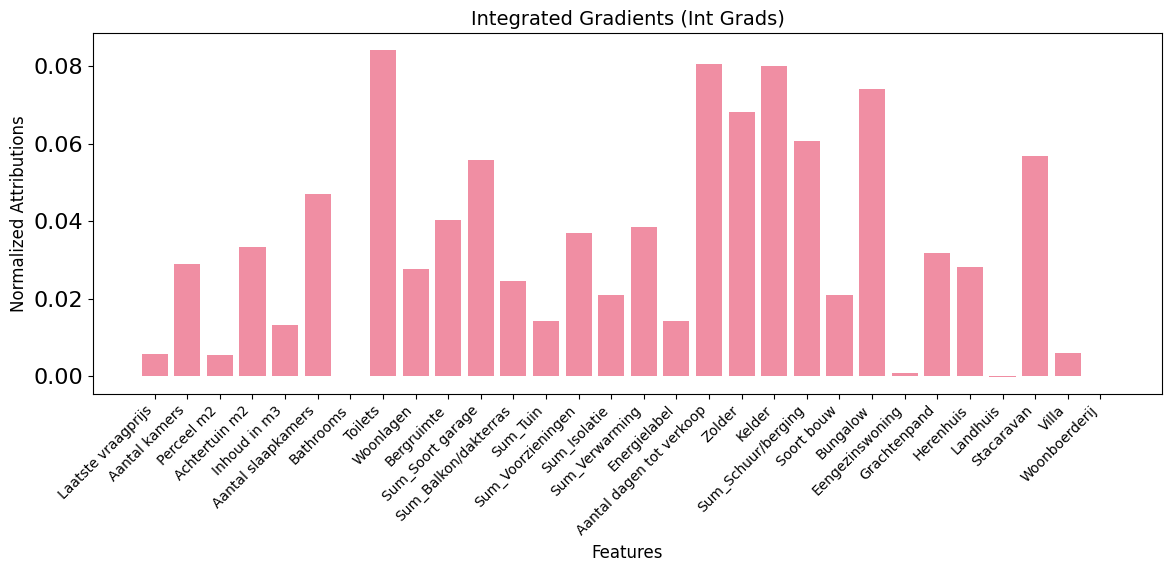

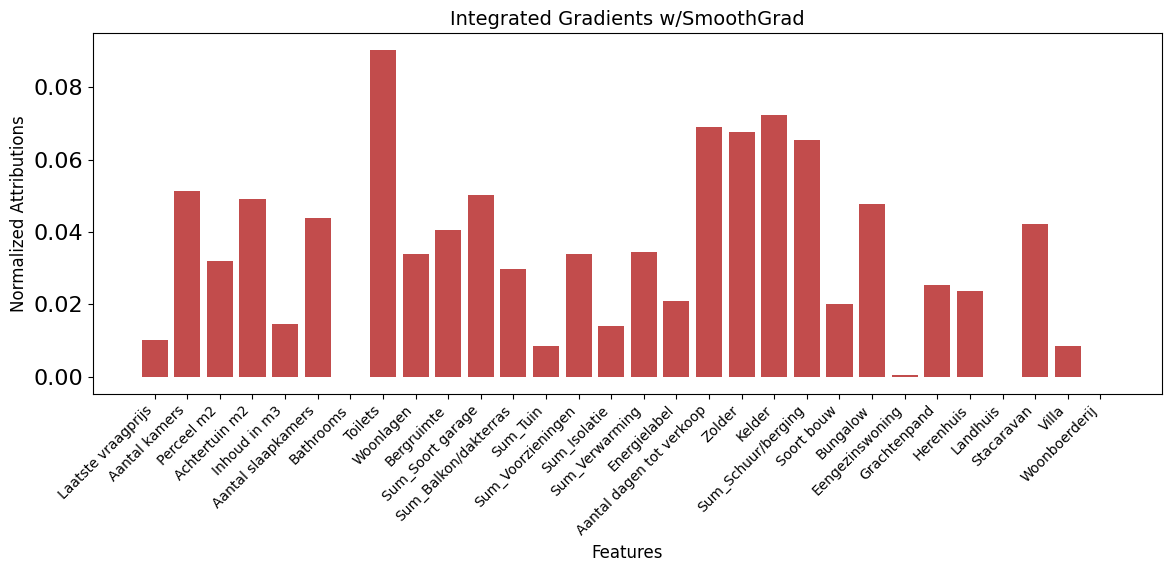

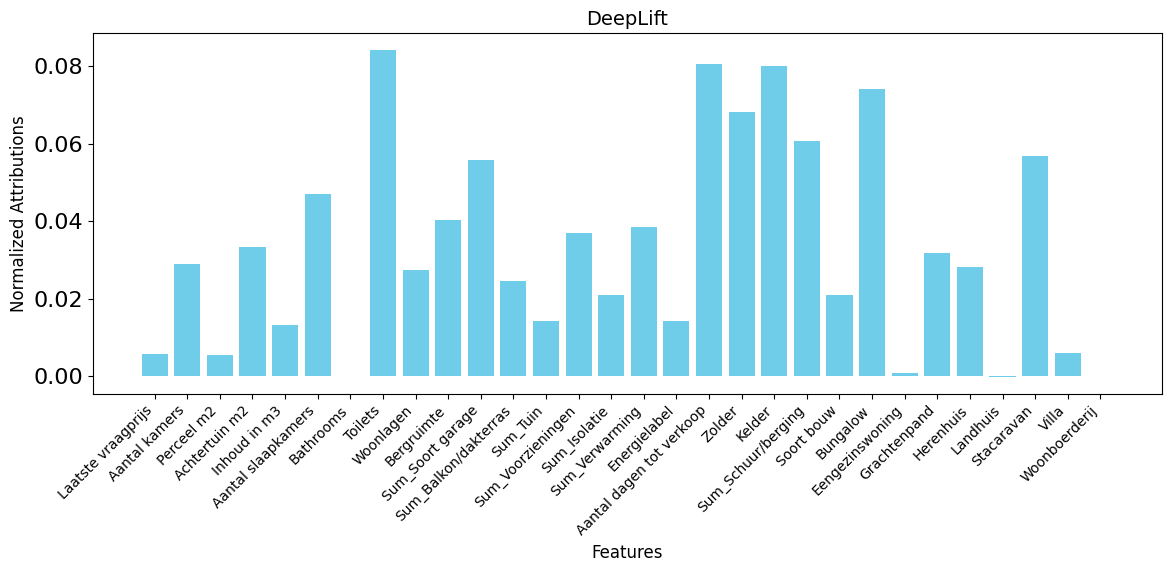

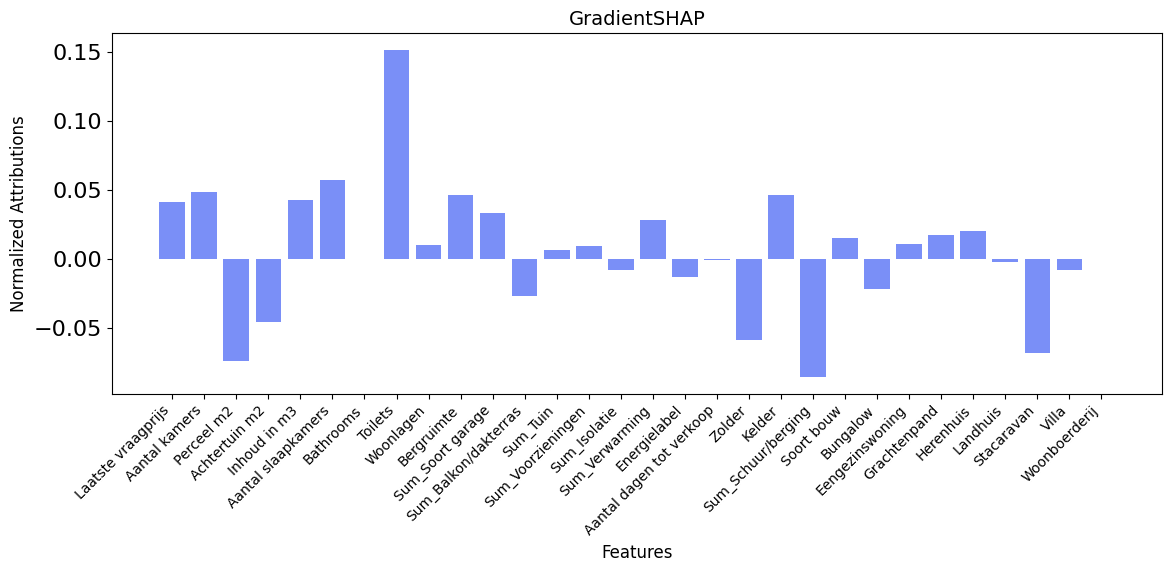

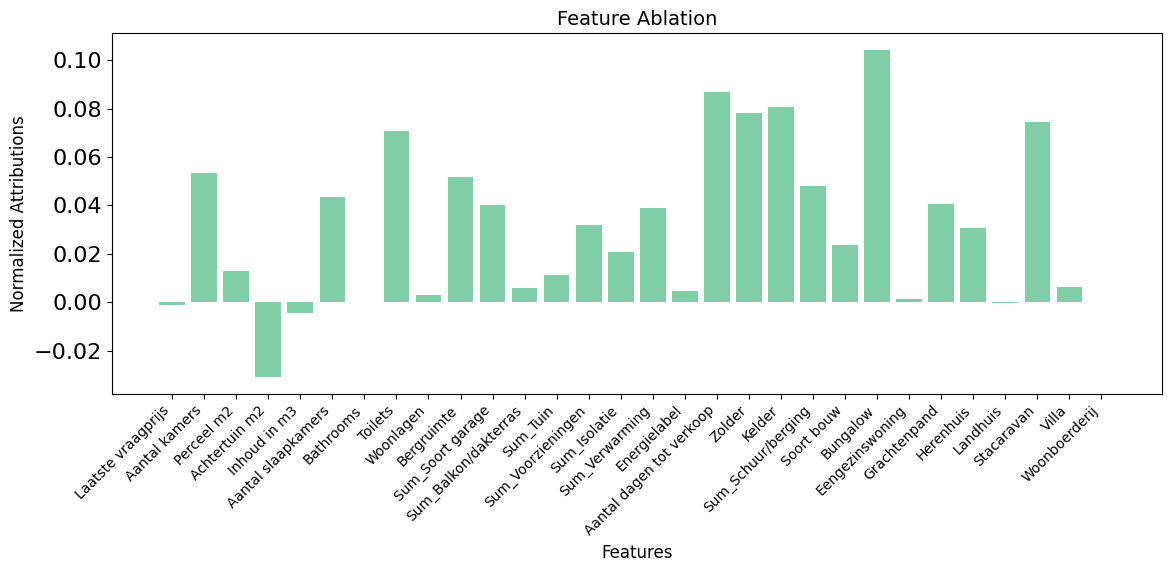

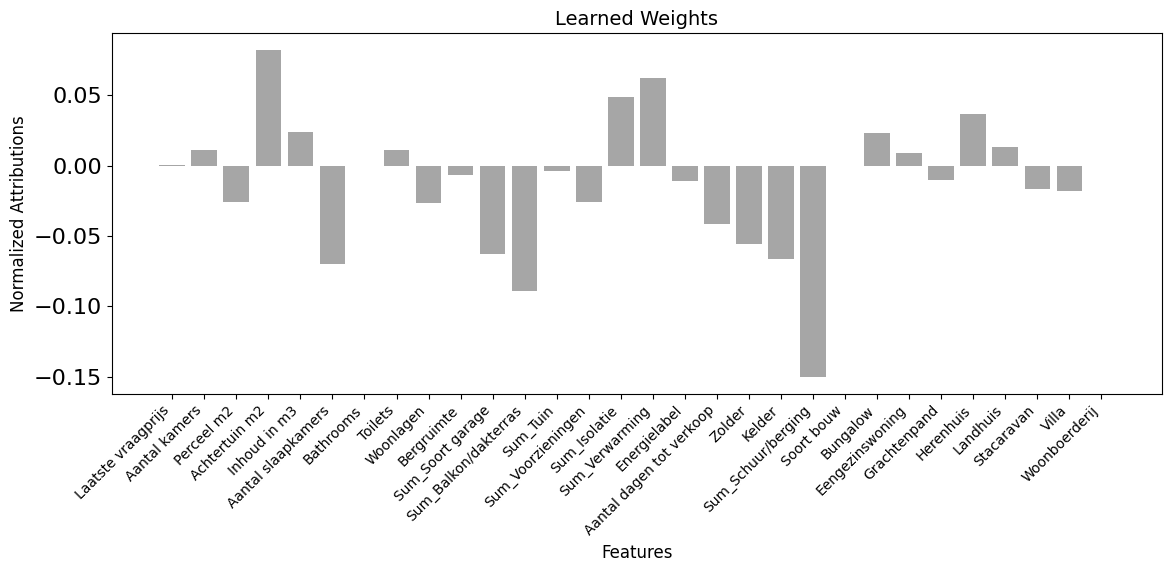

In [31]:
# Define a function to plot attributions for each method
def plot_attributions(attributions, feature_names, title, color):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(attributions)), attributions, color=color, alpha=0.7)
    plt.xticks(range(len(attributions)), feature_names, rotation=45, ha='right', fontsize=10)
    plt.title(title, fontsize=14)
    plt.ylabel('Normalized Attributions', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot each explanation method
plot_attributions(ig_attr_test_norm_sum, x_axis_data_labels, "Integrated Gradients (Int Grads)", '#eb5e7c')
plot_attributions(ig_nt_attr_test_norm_sum, x_axis_data_labels, "Integrated Gradients w/SmoothGrad", '#A90000')
plot_attributions(dl_attr_test_norm_sum, x_axis_data_labels, "DeepLift", '#34b8e0')
plot_attributions(gs_attr_test_norm_sum, x_axis_data_labels, "GradientSHAP", '#4260f5')
plot_attributions(fa_attr_test_norm_sum, x_axis_data_labels, "Feature Ablation", '#49ba81')
plot_attributions(y_axis_lin_weight, x_axis_data_labels, "Learned Weights", 'grey')

### Comparison of Explanation Methods

#### Integrated Gradients (Int Grads)
- Captures feature contributions by integrating gradients along the path from a baseline to the input.
- Shows consistent attributions across features, with strong emphasis on features like **Woonlagen**, **Aantal dagen tot verkoop**, and **Energielabel**.
- Provides a balanced view of both positive and negative contributions.

#### Integrated Gradients with SmoothGrad
- Adds noise to the input to smooth out attributions, reducing noise in the results.
- Similar to Int Grads but slightly more refined, with clearer emphasis on key features like **Woonlagen** and **Aantal dagen tot verkoop**.
- Helps reduce variability in attributions, making it easier to interpret.

#### DeepLift
- Highlights the difference in predictions between a baseline and the input, attributing the difference to features.
- Strongly emphasizes features like **Woonlagen**, **Aantal dagen tot verkoop**, and **Energielabel**.
- Captures both positive and negative contributions effectively, but the attributions may appear more spread out compared to Int Grads.

#### GradientSHAP
- Averages attributions over multiple random baselines, accounting for variability in feature importance.
- Shows higher variability in attributions, with strong emphasis on features like **Woonlagen** and **Aantal dagen tot verkoop**.
- May highlight interactions between features better than other methods.

#### Feature Ablation
- Measures the change in model output when a feature is removed, showing its direct impact.
- Strongly emphasizes features like **Aantal dagen tot verkoop**, **Woonlagen**, and **Energielabel**.
- Provides clear insights into the direct impact of features but may miss interactions.

#### Learned Weights
- Represents the raw importance of features as learned by the model's first layer.
- Focuses on features like **Aantal dagen tot verkoop** and **Energielabel**, but lacks the nuanced view of interactions or non-linear effects.
- Useful for understanding the model's raw perception of feature importance.

---

### Key Insights

#### Consistency Across Methods
- Features like **Woonlagen**, **Aantal dagen tot verkoop**, and **Energielabel** are consistently highlighted across all methods, indicating their critical importance to the model.

#### Differences in Emphasis
- **GradientSHAP** and **DeepLift** show higher variability in attributions, which may help capture feature interactions.
- **Feature Ablation** provides a direct measure of feature impact but may miss subtle interactions.
- **Integrated Gradients with SmoothGrad** offers a refined and less noisy view compared to raw Int Grads.

#### Best Performing Method
- **Integrated Gradients with SmoothGrad** strikes a good balance between clarity and consistency, making it a strong candidate for identifying key features.
- **GradientSHAP** is useful for exploring feature interactions but may be harder to interpret due to variability.

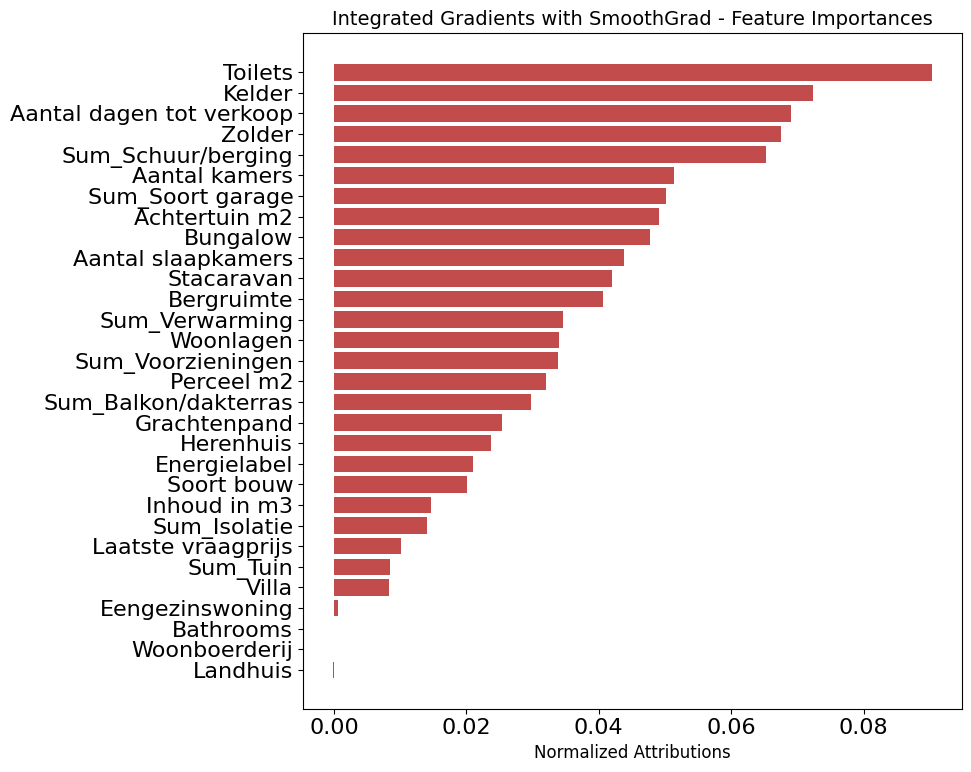

In [38]:
plt.figure(figsize=(10, 8))
sorted_indices = np.argsort(ig_nt_attr_test_norm_sum)
sorted_features = [x_axis_data_labels[i] for i in sorted_indices]
sorted_values = ig_nt_attr_test_norm_sum[sorted_indices]
plt.barh(sorted_features, sorted_values, color='#A90000', alpha=0.7)
plt.title("Integrated Gradients with SmoothGrad - Feature Importances", fontsize=14)
plt.xlabel("Normalized Attributions", fontsize=12)
plt.tight_layout()
plt.show()

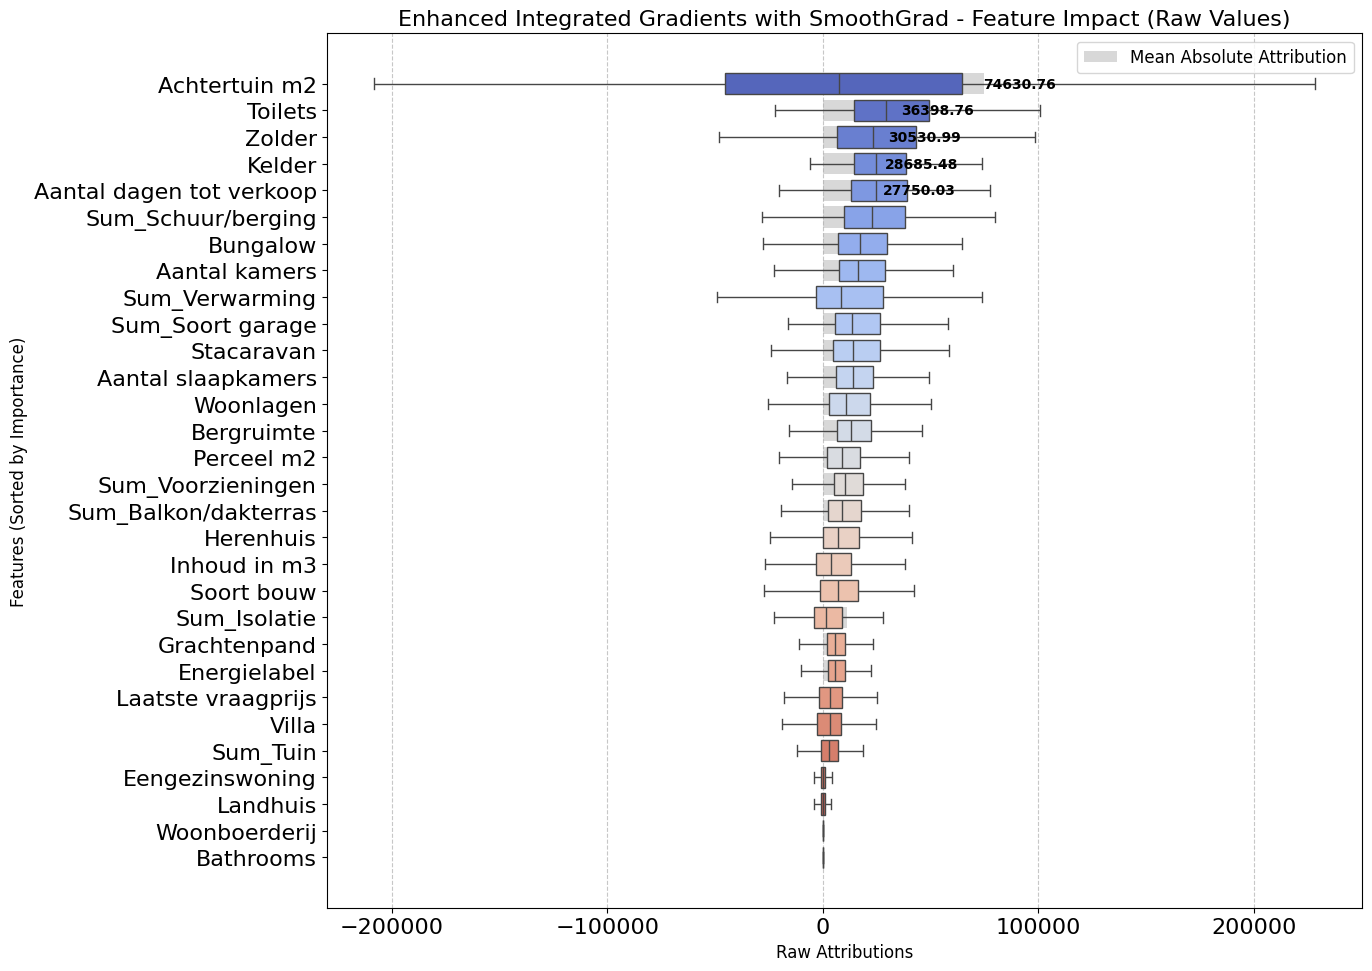

In [52]:
# Use raw attributions instead of normalized values
raw_attributions = ig_nt_attr_test.detach().numpy()

# Create a DataFrame for better handling
attributions_df = pd.DataFrame(raw_attributions, columns=x_axis_data_labels)

# Sort features by mean absolute attribution
mean_abs_attributions = attributions_df.abs().mean().sort_values(ascending=False)
sorted_features = mean_abs_attributions.index

# Plot the box plot with enhancements
plt.figure(figsize=(14, 10))

# Box plot
sns.boxplot(data=attributions_df[sorted_features], orient='h', palette="coolwarm", showfliers=False)

# Add a horizontal bar plot for mean absolute attributions
mean_values = mean_abs_attributions[sorted_features]
plt.barh(sorted_features, mean_values, color='grey', alpha=0.3, label='Mean Absolute Attribution')

# Highlight the top 5 features
top_features = sorted_features[:5]
for i, feature in enumerate(top_features):
    mean_value = mean_abs_attributions[feature]
    plt.text(mean_value, i, f"{mean_value:.2f}", va='center', ha='left', fontsize=10, color='black', fontweight='bold')

# Add horizontal grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add titles and labels
plt.title("Enhanced Integrated Gradients with SmoothGrad - Feature Impact (Raw Values)", fontsize=16)
plt.xlabel("Raw Attributions", fontsize=12)
plt.ylabel("Features (Sorted by Importance)", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

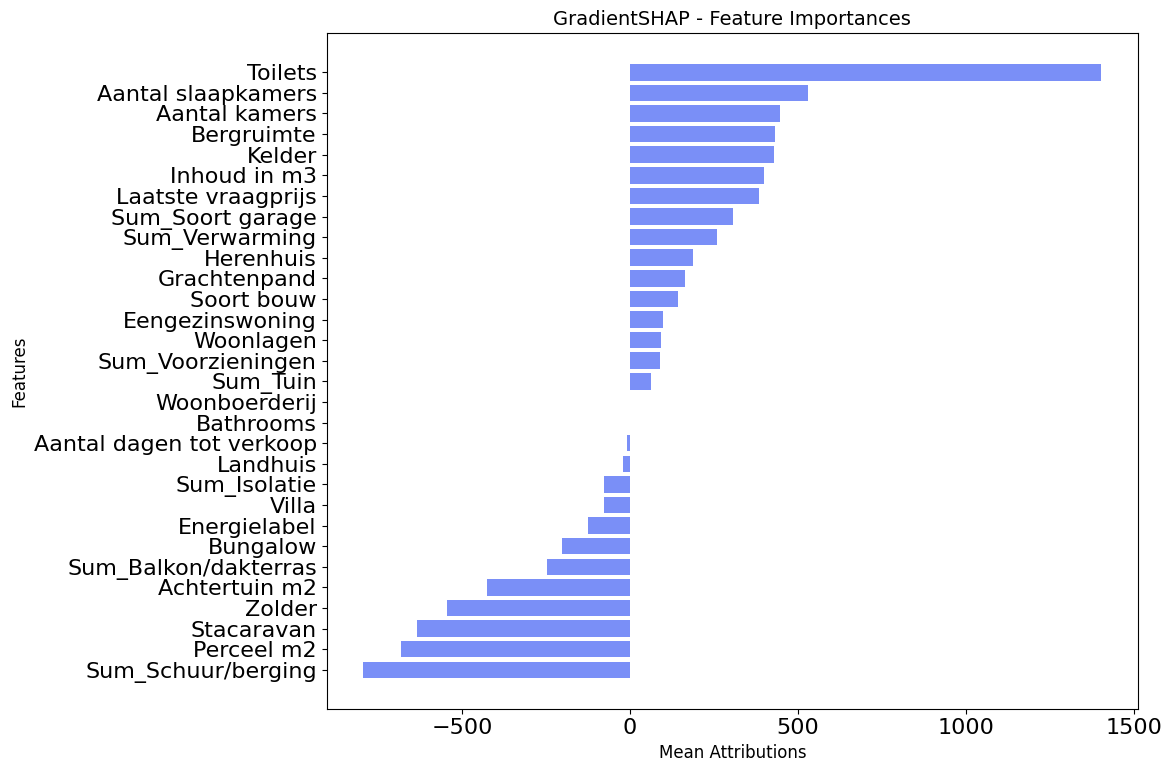

In [53]:
# Calculate mean attributions for GradientSHAP
gs_attr_test_mean = gs_attr_test.detach().numpy().mean(axis=0)

# Sort features by mean attribution
sorted_indices = np.argsort(gs_attr_test_mean)
sorted_features = [x_axis_data_labels[i] for i in sorted_indices]
sorted_values = gs_attr_test_mean[sorted_indices]

# Plot horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_values, color='#4260f5', alpha=0.7)
plt.title("GradientSHAP - Feature Importances", fontsize=14)
plt.xlabel("Mean Attributions", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

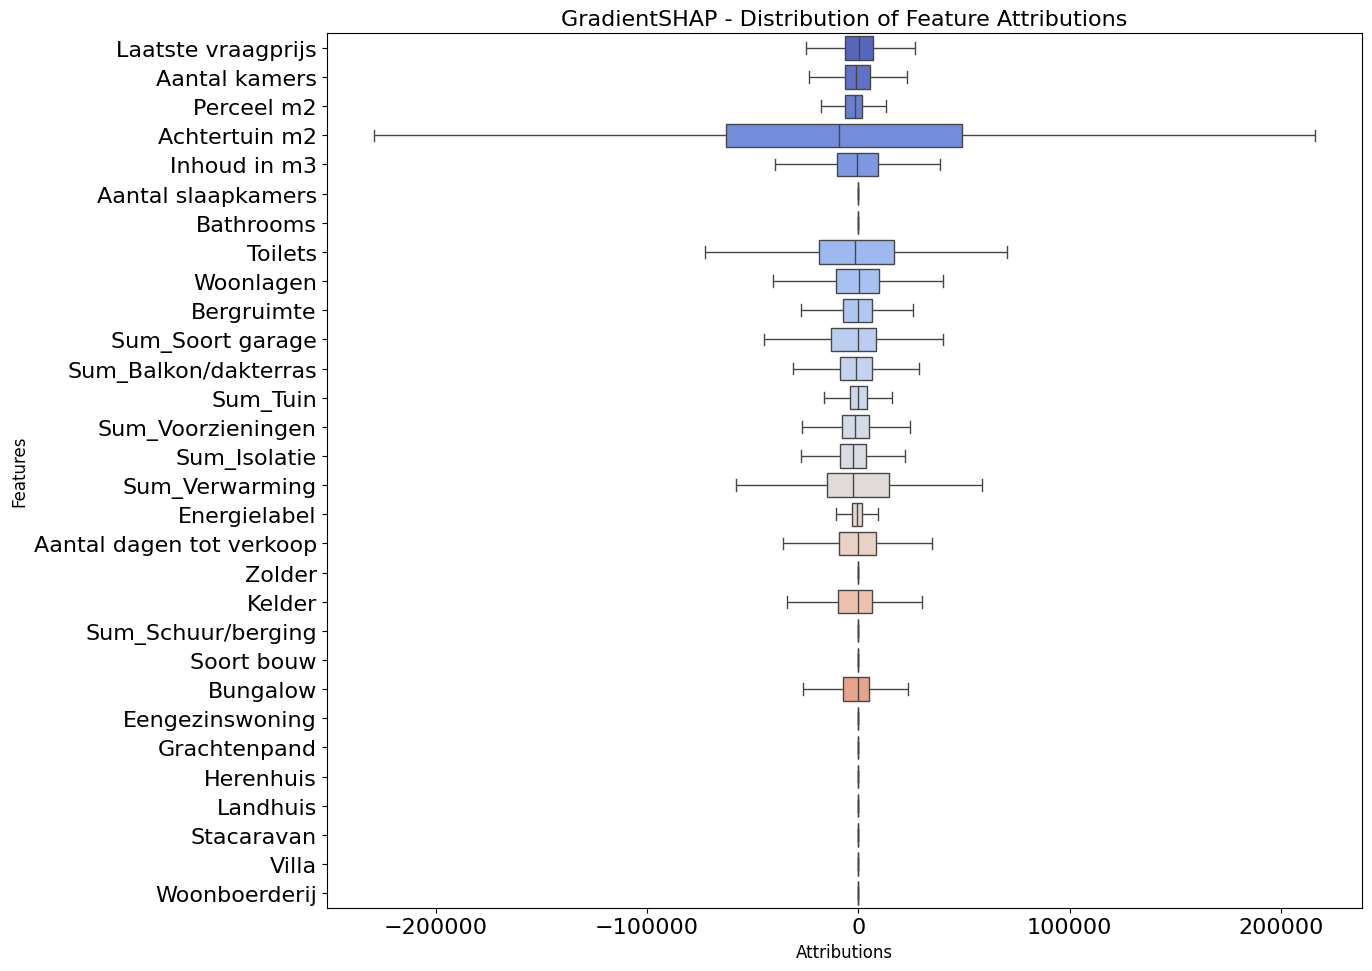

In [54]:
# Convert GradientSHAP attributions to DataFrame
gs_attr_test_df = pd.DataFrame(gs_attr_test.detach().numpy(), columns=x_axis_data_labels)

# Plot box plot
plt.figure(figsize=(14, 10))
sns.boxplot(data=gs_attr_test_df, orient='h', palette="coolwarm", showfliers=False)
plt.title("GradientSHAP - Distribution of Feature Attributions", fontsize=16)
plt.xlabel("Attributions", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

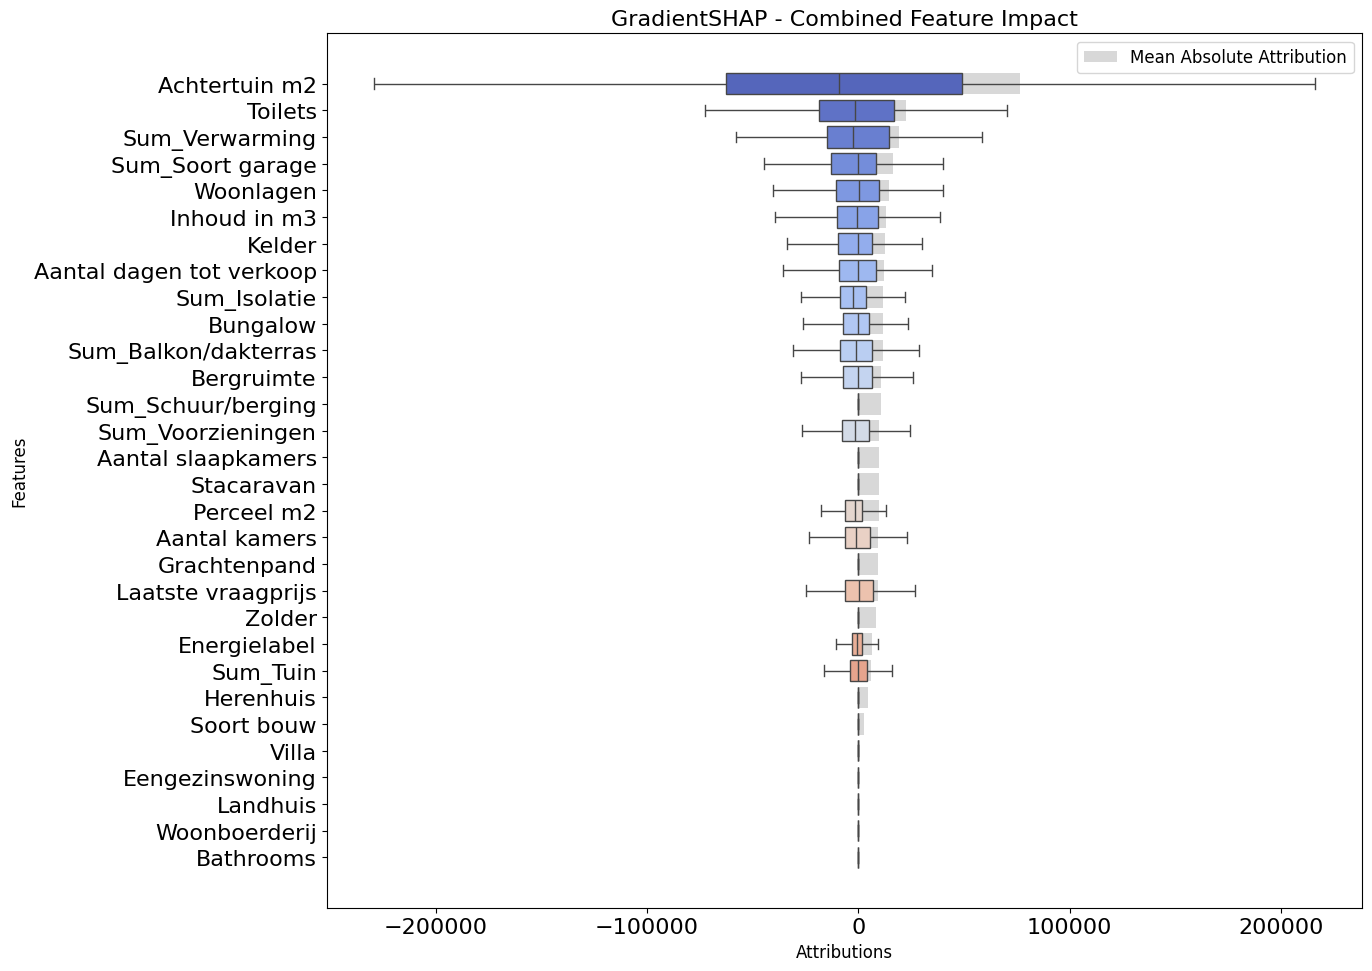

In [57]:
# Calculate mean attributions
mean_values = gs_attr_test_df.abs().mean().sort_values(ascending=False)
sorted_features = mean_values.index

# Plot combined bar and box plot
plt.figure(figsize=(14, 10))
sns.boxplot(data=gs_attr_test_df[sorted_features], orient='h', palette="coolwarm", showfliers=False)
plt.barh(sorted_features, mean_values, color='grey', alpha=0.3, label='Mean Absolute Attribution')
plt.title("GradientSHAP - Combined Feature Impact", fontsize=16)
plt.xlabel("Attributions", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### 📊 1. Combined Feature Impact (First Plot)

**Purpose**: Combines mean absolute attribution (gray bars) with actual signed attributions (colored bars).

#### Top Features:
- **Achtertuin m2**, **Toilets**, **Sum_Verwarming** — largest impact, mostly positive.

#### Insight:
- **Achtertuin m2** has a huge and consistent positive effect on the model's output (likely price).
- Some features show variability in direction, indicating interaction effects.

---

### 📈 2. Distribution of Feature Attributions (Second Plot)

**Purpose**: Shows the spread of attributions for each feature.

#### Top Spread:
- **Achtertuin m2**, **Laatste vraagprijs**, and **Perceel m2** show wide attribution ranges — big influence, but can be positive or negative.

#### Insight:
- **Achtertuin m2** stands out again for its massive, variable impact.
- **Laatste vraagprijs** and **Perceel m2** also contribute variably depending on the context.

---

### 🔍 3. Mean Feature Importances (Third Plot)

**Purpose**: Shows average signed contribution.

#### Top Positive Features:
- **Toilets**, **Aantal slaapkamers**, **Aantal kamers** — consistently increase model output.

#### Top Negative Features:
- **Sum_Schuur/berging**, **Perceel m2**, **Stacaravan** — decrease model output on average.

#### Insight:
- Even though **Achtertuin m2** had high impact (plots 1 & 2), its average effect is negative here, suggesting a complex interaction or skewed cases.

---

### 🧠 Key Takeaways:
1. **Achtertuin m2** is the most impactful but context-sensitive.
2. **Toilets**, **Bedrooms**, and **Room Count** are strong positive contributors across the board.
3. Some features (e.g., **Sum_Schuur/berging**, **Stacaravan**) often correlate with lower value.

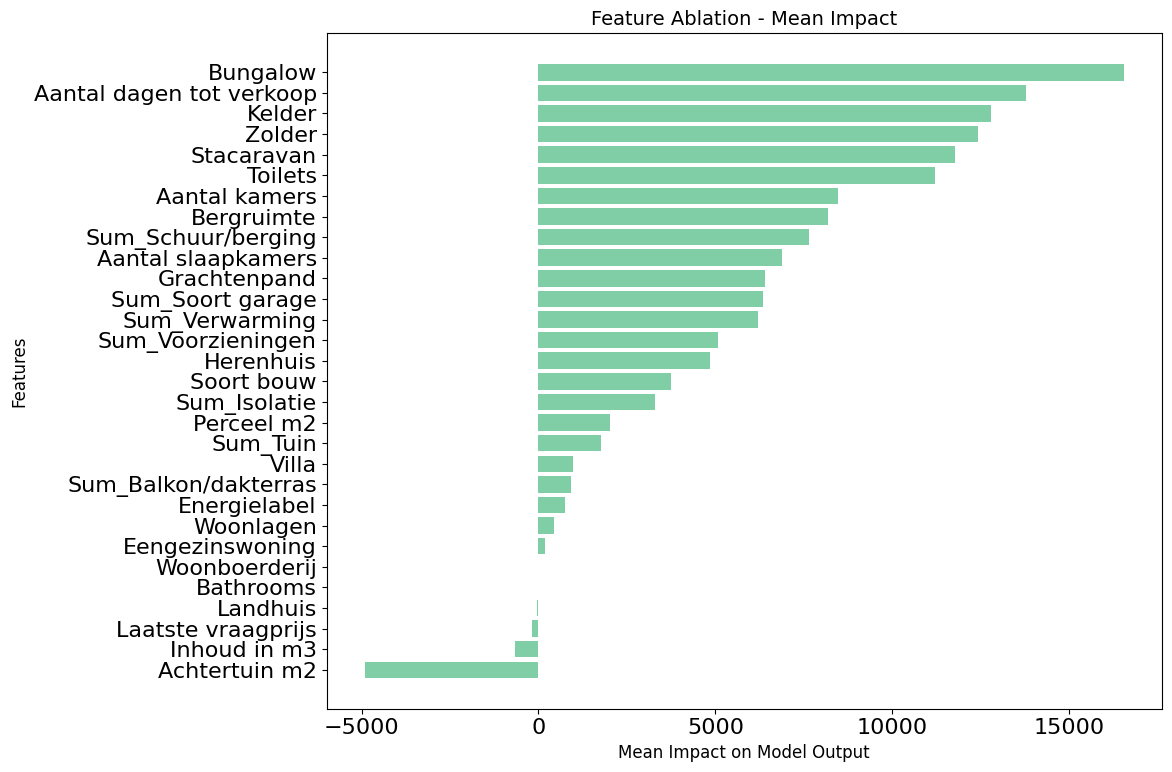

In [59]:
# Horizontal Bar Chart for Feature Ablation
fa_attr_test_mean = fa_attr_test.detach().numpy().mean(axis=0)
sorted_indices = np.argsort(fa_attr_test_mean)
sorted_features = [x_axis_data_labels[i] for i in sorted_indices]
sorted_values = fa_attr_test_mean[sorted_indices]

plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_values, color='#49ba81', alpha=0.7)
plt.title("Feature Ablation - Mean Impact", fontsize=14)
plt.xlabel("Mean Impact on Model Output", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

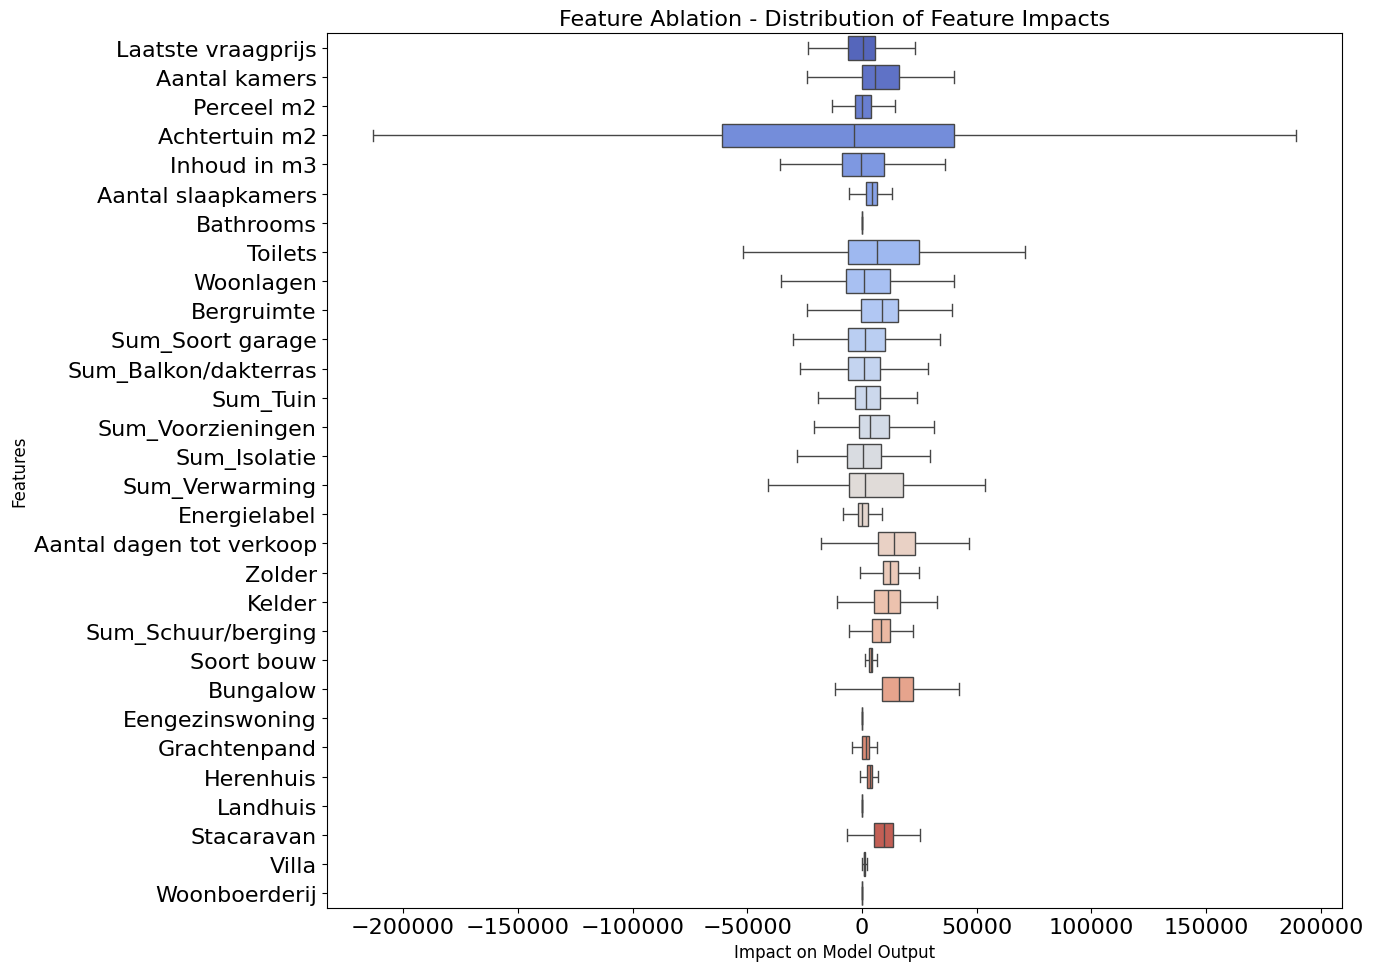

In [60]:
# Box Plot for Feature Ablation
fa_attr_test_df = pd.DataFrame(fa_attr_test.detach().numpy(), columns=x_axis_data_labels)

plt.figure(figsize=(14, 10))
sns.boxplot(data=fa_attr_test_df, orient='h', palette="coolwarm", showfliers=False)
plt.title("Feature Ablation - Distribution of Feature Impacts", fontsize=16)
plt.xlabel("Impact on Model Output", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

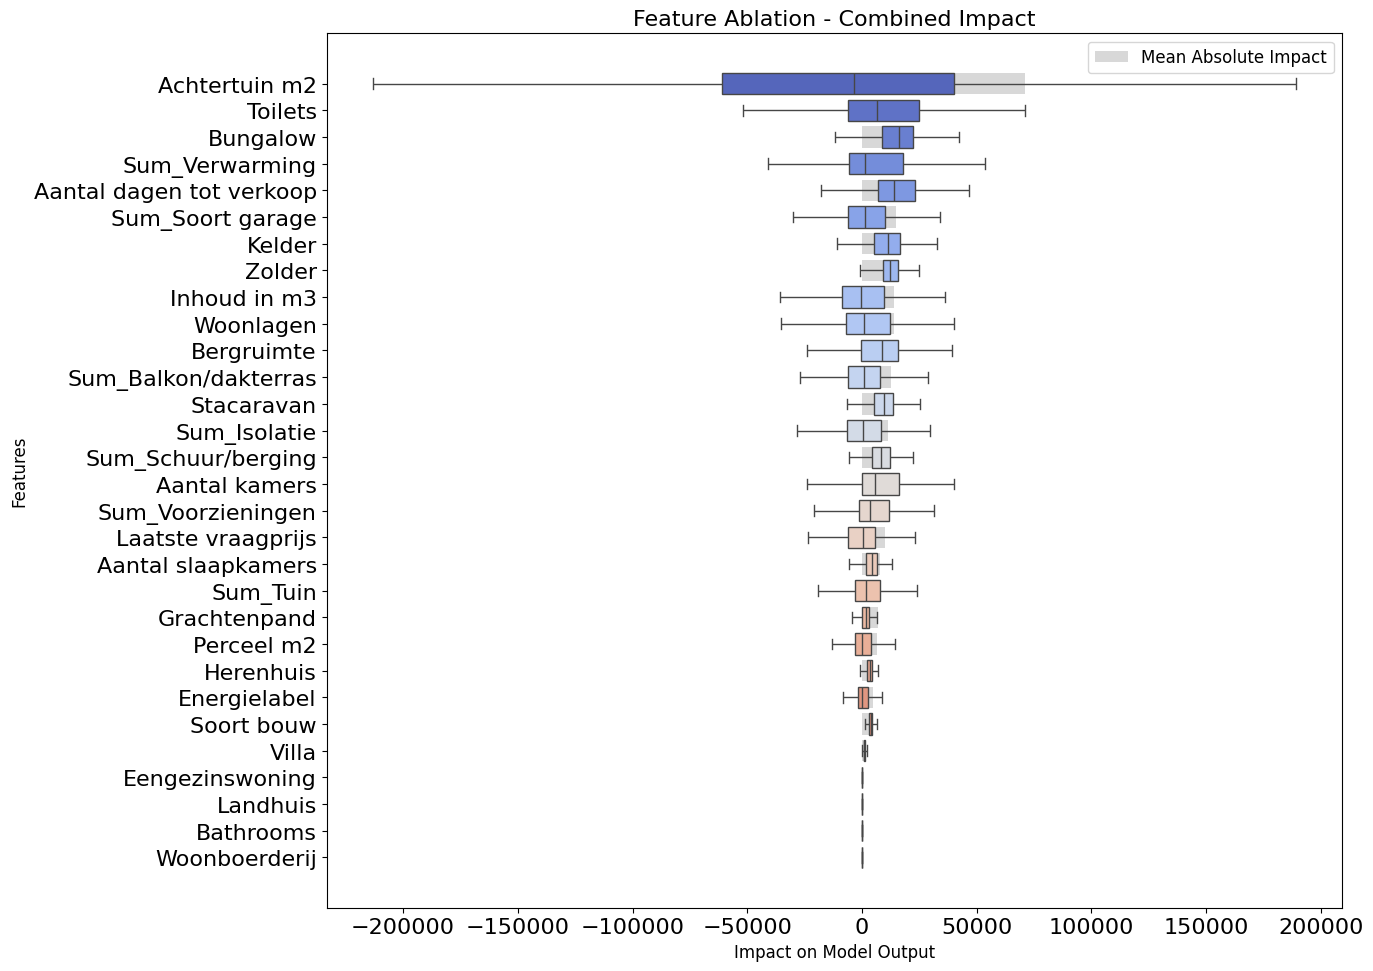

In [61]:
# Combined Bar and Box Plot for Feature Ablation
mean_values = fa_attr_test_df.abs().mean().sort_values(ascending=False)
sorted_features = mean_values.index

plt.figure(figsize=(14, 10))
sns.boxplot(data=fa_attr_test_df[sorted_features], orient='h', palette="coolwarm", showfliers=False)
plt.barh(sorted_features, mean_values, color='grey', alpha=0.3, label='Mean Absolute Impact')
plt.title("Feature Ablation - Combined Impact", fontsize=16)
plt.xlabel("Impact on Model Output", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#### 1. Mean Impact (1st Plot)
**What it shows**: Average change in model output when each feature is ablated (removed).

**Key insights**:
- **Bungalow**, **Aantal dagen tot verkoop**, and **Kelder** have the highest average positive impact.
- Features like **Achtertuin m2** and **Inhoud in m3** have negative impacts, meaning removing them improves predictions slightly.

**Use case**: Great for identifying which features individually boost or degrade model performance on average.

---

#### 2. Combined Impact with Mean Absolute (2nd Plot)
**What it shows**: Directional impact (blue/red) + gray bars showing mean absolute impact (magnitude only).

**Key insights**:
- **Achtertuin m2** has the strongest absolute impact, though directionally negative.
- **Toilets**, **Bungalow**, and **Sum_Verwarming** follow with both strong magnitude and meaningful directional shifts.

**Use case**: Useful to balance importance (magnitude) and directionality. Ideal for model explainability discussions.

---

#### 3. Impact Distribution (3rd Plot)
**What it shows**: Full distribution (spread) of model output changes per feature removal.

**Key insights**:
- **Achtertuin m2** again shows a wide and skewed impact distribution — it’s influential but unstable.
- **Laatste vraagprijs** and **Aantal kamers** are impactful with tight, consistent effects.

**Use case**: Helps detect features with high variance or unreliable effects — useful for risk-sensitive decisions.

---

#### Summary
- **Most influential & consistent features**: **Laatste vraagprijs**, **Aantal kamers**, **Toilets**.
- **High but volatile influence**: **Achtertuin m2**, **Inhoud in m3**.
- **Unexpected high contributors**: House types like **Bungalow** or **Stacaravan** — likely proxies for broader property characteristics.
